In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

device = "cuda" if torch.cuda.is_available() else 'cpu'


%load_ext autoreload
%autoreload 2

import tqdm
tqdm.__version__

'4.62.3'

In [2]:
from tvae.data.mnist import Preprocessor
from tvae.utils.logging import configure_logging, get_dirs
from torchvision import datasets
from functools import partial
from torch.utils.data import DataLoader


In [ ]:
transform_config = {
        #'wandb_on': True,
        #'lr': 1e-4,
        #'momentum': 0.9,
        #'batch_size': 8,
        #'max_epochs': 100,
        #'eval_epochs': 5,
        'dataset': 'MNIST',
        'train_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
        'test_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340', 
        'train_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
        'test_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
        'train_scale_set': '0.60 0.64 0.68 0.72 0.76 0.79 0.83 0.87 0.91 0.95 0.99 1.03 1.07 1.11 1.14 1.18 1.22 1.26',
        'test_scale_set': '0.60 0.64 0.68 0.72 0.76 0.79 0.83 0.87 0.91 0.95 0.99 1.03 1.07 1.11 1.14 1.18 1.22 1.26',
        'pct_val': 0.2,
        'random_crop': 28,
        'seed': 1,
        #'n_caps': 18,
        #'cap_dim': 18,
        #'n_transforms': 18,
        #'mu_init': 30.0,
        #'n_off_diag': 1,
        #'group_kernel': (18, 18, 1),
        #'n_is_samples': 10
        }
#config['savedir'], config['data_dir'], config['wandb_dir'] = get_dirs()

#preprocessor = Preprocessor(config)
#train_dataset, val_dataset, test_dataset = preprocessor.load_datasets()


In [36]:
from pythae.data.datasets import DatasetOutput
from torch.utils.data import Dataset
from tvae.data.transforms import AddPerspectiveTransformationDims, AddRandomTransformationDims, AddDualTransformationDims, To_Color
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from PIL import Image


def string_to_list(string):
    l = list(map(float, str(string).split(' ')))
    return l


class DuplicateTargets(object):
    def __init__(self, n_transforms):
        self.n_transforms = n_transforms

    def __call__(self, target):
        """
        Args:
            tensor (Tensor): Target tensor (N,)
        Returns:
            Tensor: Target tensor duplicated to the number of transformations (N * n_transforms)
        """
        return torch.tensor(target).view(-1, 1).repeat(1, self.n_transforms).view(-1,)

    def __repr__(self):
        format_string = self.__class__.__name__ 
        return format_string

def get_transform(config):

    train_angle_set = string_to_list(config['train_angle_set'])
    test_angle_set = string_to_list(config['test_angle_set'])
    train_color_set = list(map(lambda x: np.radians(x) - np.pi, string_to_list(config['train_color_set'])))
    test_color_set = list(map(lambda x: np.radians(x) - np.pi, string_to_list(config['test_color_set'])))
    train_scale_set = string_to_list(config['train_scale_set'])
    test_scale_set = string_to_list(config['test_scale_set'])
    n_transforms_train = len(train_angle_set) * len(train_color_set) * len(train_scale_set)
    n_transforms_test = len(test_angle_set) * len(test_color_set) * len(test_scale_set)

    random_crop = config['random_crop']

    base_transforms_train = base_transforms_test = [
                                   transforms.RandomCrop(random_crop),
                                   transforms.ToTensor()]

    if len(train_color_set) > 1:
        base_transforms_train = [To_Color()] + base_transforms_train
        base_transforms_test = [To_Color()] + base_transforms_test

    base_transforms_train = base_transforms_train + [AddRandomTransformationDims(train_angle_set, train_color_set, train_scale_set)] 
    base_transforms_test =  base_transforms_test + [AddRandomTransformationDims(test_angle_set, test_color_set, test_scale_set)]

    transforms_train = transforms.Compose(base_transforms_train)
    target_transform_train = DuplicateTargets(n_transforms_train)
    transforms_test = transforms.Compose(base_transforms_test)
    target_transform_test = DuplicateTargets(n_transforms_test)

    return transforms_train, target_transform_train, transforms_test, target_transform_test

In [ ]:
class ColorMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None, target_transform=None):

        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return DatasetOutput(data=img)

In [ ]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_data = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_data = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [ ]:
transforms_train, target_transform_train, transforms_test, target_transform_test = get_transform(transform_config)

In [ ]:
train_dataset = ColorMNIST(train_data, transform=tr)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8,
                                       drop_last=True)

In [ ]:
im, l = next(iter(train_loader))

import matplotlib.pyplot as plt
import torch
import numpy as np


fig, axes = plt.subplots(nrows=8, ncols=18, figsize=(18, 8))

for i in range(8):
    for j in range(18):
        axes[i][j].imshow(np.moveaxis(im[i, j].cpu().squeeze(0).squeeze(0).numpy(), 0, 2), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [7]:
train_data = torch.load(os.path.join('/home/clement/Documents/TopographicVAE/tvae/data/train_12_long_color_mnist.pt'), map_location=device)#[:10000]
eval_data = torch.load(os.path.join('/home/clement/Documents/TopographicVAE/tvae/data/val_12_long_color_mnist.pt'), map_location=device)#[:5000]


print(train_data.shape, eval_data.shape)

torch.Size([48000, 12, 3, 28, 28]) torch.Size([12000, 12, 3, 28, 28])


In [86]:
from utils import make_batched_masks

m = make_batched_masks(eval_data, 0.32, 129)
m.shape

torch.Size([12000, 12])

In [88]:
m[-5:]

tensor([[1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.],
        [1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.],
        [1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.]])

In [77]:
train_mask = torch.zeros(train_data.shape[:2])
eval_mask = torch.zeros(eval_data.shape[:2])

prob_missing_data = 0.75
batch_size = 129



for i in range(int(train_data.shape[0] / batch_size)):
#i = 0

    prob = ((1 - prob_missing_data) - 2 / train_data.shape[1]) * train_data.shape[1] / (train_data.shape[1] - 2)

    train_bern = torch.distributions.Bernoulli(probs=prob).sample((train_data.shape[1]-2,))
    #eval_bern = torch.distributions.Bernoulli(probs=prob).sample((eval_data.shape[1]-2,))

    _train_mask = torch.zeros(train_data.shape[1])
    #_eval_mask = torch.zeros(eval_data.shape[1])

    _train_mask[:2] = 1
    _train_mask[2:] = train_bern
    #_eval_mask[:2] = 1
    #_eval_mask[2:] = eval_bern

    train_idx = np.random.rand(*_train_mask.shape).argsort(axis=-1)
    #eval_idx = np.random.rand(*_eval_mask.shape).argsort(axis=-1)

    _train_mask = np.take_along_axis(_train_mask, train_idx, axis=-1)
    #_eval_mask = np.take_along_axis(_eval_mask, eval_idx, axis=-1)

    #print(train_mask[i*batch_size:(i+1)*batch_size].shape, _train_mask.repeat(batch_size, 1).shape)

    train_mask[i*batch_size:(i+1)*batch_size] = _train_mask.repeat(batch_size, 1)
    #eval_mask[i*batch_size:(i+1)*batch_size] = _eval_mask.repeat(batch_size, 1)

if train_data.shape[0] % batch_size > 0:
    prob = ((1 - prob_missing_data) - 2 / train_data.shape[1]) * train_data.shape[1] / (train_data.shape[1] - 2)

    train_bern = torch.distributions.Bernoulli(probs=prob).sample((train_data.shape[1]-2,))
    #eval_bern = torch.distributions.Bernoulli(probs=prob).sample((eval_data.shape[1]-2,))

    _train_mask = torch.zeros(train_data.shape[1])
    #_eval_mask = torch.zeros(eval_data.shape[1])

    _train_mask[:2] = 1
    _train_mask[2:] = train_bern
    #_eval_mask[:2] = 1
    #_eval_mask[2:] = eval_bern

    train_idx = np.random.rand(*_train_mask.shape).argsort(axis=-1)
    #eval_idx = np.random.rand(*_eval_mask.shape).argsort(axis=-1)

    _train_mask = np.take_along_axis(_train_mask, train_idx, axis=-1)
    #_eval_mask = np.take_along_axis(_eval_mask, eval_idx, axis=-1)

    #print(train_mask[i*batch_size:(i+1)*batch_size].shape, _train_mask.repeat(batch_size, 1).shape)

    train_mask[-(train_data.shape[0] % batch_size):] = _train_mask.repeat((train_data.shape[0] % batch_size), 1)





In [80]:
train_mask[-13:]

tensor([[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [61]:
eval_mask.sum() / np.prod(eval_mask.shape)

tensor(0.2590)

In [38]:
train_bern.repeat(batch_size, 1)

tensor([[1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],


In [8]:
train_data.reshape(-1)

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [10]:
a = torch.zeros((train_data.shape[:2]))
a[:, :2] = 1
a.sum(dim=-1)

tensor([2., 2., 2.,  ..., 2., 2., 2.])

In [26]:
(0.78 - 2 / 12) * 12 / 10

0.7360000000000001

In [28]:
bern = torch.distributions.Bernoulli(probs=0.736).sample((train_data.shape[0], train_data.shape[1]-2))
a[:, 2:] = bern

In [29]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

a_shuf = shuffle_along_axis(a, axis=-1)

In [30]:
a_shuf.sum()/ (48000*12)

tensor(0.7800)

In [30]:
probs = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]).astype(np.float)
probs /= probs.sum()
probs = torch.tensor(probs)

np.random.choice(np.arange(train_data.shape[1]), p=probs)

/tmp/ipykernel_10962/4156233049.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  probs = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]).astype(np.float)


11

In [15]:
np.arange(train_data.shape[1]).shape

(12,)

In [12]:
(a_shuf.sum(dim=-1)<2).sum()

tensor(0)

In [21]:
torch.save(mask, '../../data/color')

tensor(0.4998)

In [56]:
from pythae.data.datasets import DatasetOutput
from torch.utils.data import Dataset


class DynBinarizedMNIST(Dataset):
    def __init__(self, data):
        self.data = data.type(torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        #x = (x > torch.distributions.Uniform(0, 1).sample(x.shape).to(x.device)).float()
        return DatasetOutput(data=x)

In [57]:
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput
import torch.nn as nn


### Define paper encoder network
class VAEEncoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim


        self.fc1 = nn.Linear(np.prod(args.input_dim), 200)
        self.fc2 = nn.Linear(200, 200)

        self.embedding = nn.Linear(200, self.latent_dim)
        self.log_var = nn.Linear(200, self.latent_dim)
        #self.context = nn.Linear(200, self.context_dim)

    def forward(self, x):
        output = ModelOutput()

        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        #output["context"] = self.context(out)

        return output

### Define paper decoder network
class VAEDecoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc1 = nn.Linear(self.latent_dim, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, np.prod(args.input_dim))


    def forward(self, z: torch.Tensor):

        output = ModelOutput()

        out = torch.relu(self.fc1(z))
        out = torch.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output



### Define paper encoder network
class TimeEncoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.context_dim = args.context_dim


        self.fc1 = nn.Linear(np.prod(args.input_dim), 500)
        self.fc2 = nn.Linear(500, 200)

        self.time_fc1 = nn.Linear(1, 50)
        self.time_fc2 = nn.Linear(50, 50)

        self.embedding = nn.Linear(250, self.latent_dim)
        self.log_var = nn.Linear(250, self.latent_dim)
        #self.context = nn.Linear(250, self.context_dim)

    def forward(self, x, t=None):
        output = ModelOutput()

        out = torch.relu(self.fc1(x.reshape(-1, np.prod(self.input_dim))))
        out = torch.relu(self.fc2(out))

        time_out = torch.relu(self.time_fc1(t))
        time_out = torch.relu(self.time_fc2(time_out))
        out = torch.cat((out, time_out), dim=-1)

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        #output["context"] = self.context(out)

        return output

### Define paper decoder network
class TimeDecoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc1 = nn.Linear(self.latent_dim, 500)
        self.fc2 = nn.Linear(500, 200)

        self.time_fc1 = nn.Linear(1, 50)
        self.time_fc2 = nn.Linear(50, 50)

        self.fc3 = nn.Linear(250, np.prod(args.input_dim))


    def forward(self, z: torch.Tensor, t=None):

        output = ModelOutput()

        out = torch.relu(self.fc1(z))
        out = torch.relu(self.fc2(out))

        time_out = torch.relu(self.time_fc1(t))
        time_out = torch.relu(self.time_fc2(time_out))
        out = torch.cat((out, time_out), dim=-1)

        out = torch.sigmoid(self.fc3(out))

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output


### Define paper encoder network
class Encoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.context_dim = args.context_dim

        self.fc = nn.Sequential(
            nn.Linear(np.prod(args.input_dim), 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
        )

        self.embedding = nn.Linear(256, self.latent_dim)
        self.log_var = nn.Linear(256, self.latent_dim)
        self.context = nn.Linear(256, self.context_dim)

    def forward(self, x):
        output = ModelOutput()

        out = self.fc(x.reshape(-1, np.prod(self.input_dim)))

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        output["context"] = self.context(out)

        return output

### Define paper decoder network
class Decoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, np.prod(self.input_dim)),
            nn.Sigmoid(),
        )


    def forward(self, z: torch.Tensor):

        output = ModelOutput()

        out = self.fc(z)

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output



## VAE

## CVAE

In [ ]:
from pythae.models import LCVAE, LCVAE_Config
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim


config = LCVAE_Config(
    input_dim=(1, 28, 28),
    latent_dim=2,
    n_obs_per_ind=8
)

encoder = TimeEncoder(config)
decoder = TimeDecoder(config)

vae = LCVAE(config, encoder, decoder).cuda()


#train_dataset = DynBinarizedMNIST(train_data.reshape(-1, 8, 784))
#eval_dataset = DynBinarizedMNIST(eval_data.reshape(-1, 8, 784))

training_config = BaseTrainerConfig(
    num_epochs=1000,
    learning_rate=1e-3,
    batch_size=100
)

### Optimizer
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
vae_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    vae_optimizer, milestones=[10000], gamma=10**(-1/7), verbose=True
)

vae_trainer = BaseTrainer(
        model=vae,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        training_config=training_config,
        optimizer=vae_optimizer,
        scheduler=vae_scheduler,
        callbacks=None,
    )

In [ ]:
_ = vae({'data': train_data[:5].cuda().reshape((-1, 8, 28*28)).float()}, epoch=0)

In [ ]:
vae_trainer.train()

In [ ]:
model_rec = vae_trainer._best_model

In [ ]:
z = torch.rand(10, 2).cuda()
gen = model_rec.generate(z).reshape(z.shape[0], 8, -1)
gen.shape

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(gen))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [ ]:
inp = iter(vae_trainer.eval_loader).next()

emb = model_rec(inp).z.detach().cpu()
recon = model_rec(inp).recon_x.detach().cpu()

In [ ]:
plt.scatter(emb[:8, 0], emb[:8, 1])

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [ ]:
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim


config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=64
)

encoder = VAEEncoder(config)
decoder = VAEDecoder(config)

vae = VAE(config, encoder, decoder).cuda()


train_dataset = DynBinarizedMNIST(train_data.reshape(-1, 784))
eval_dataset = DynBinarizedMNIST(eval_data.reshape(-1, 784))

training_config = BaseTrainerConfig(
    num_epochs=10,
    learning_rate=1e-3,
    batch_size=100
)

### Optimizer
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
vae_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    vae_optimizer, milestones=[10000], gamma=10**(-1/7), verbose=True
)

vae_trainer = BaseTrainer(
        model=vae,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        training_config=training_config,
        optimizer=vae_optimizer,
        scheduler=vae_scheduler,
        callbacks=None,
    )

In [ ]:
vae_trainer.train()

In [ ]:
model_rec = vae#trainer._best_model

In [ ]:
z = torch.rand(10, 64).cuda()
gen = model_rec.decoder(z).reconstruction.detach().cpu()
gen.shape

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(gen))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [ ]:
inp = iter(vae_trainer.eval_loader).next()

emb = model_rec(inp).z.detach().cpu()

In [ ]:
plt.scatter(emb[:8, 0], emb[:8, 1])

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

## LVAE

In [61]:
from pythae.models import LVAE_IAF, LVAE_IAF_Config

config = LVAE_IAF_Config(
    input_dim=(3, 28, 28),
    n_obs_per_ind=train_data.shape[1],
    latent_dim=32,
    n_hidden_in_made=3,
    n_made_blocks=2,
    warmup=101,
    context_dim=32,
    prior="vamp",
    posterior="gaussian",
    vamp_number_components=500,
    linear_scheduling_steps=0
)

encoder = Encoder(config)
decoder = Decoder(config)

model = LVAE_IAF(config, encoder, decoder).cuda()
model

LVAE_IAF(
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=2352, bias=True)
      (5): Sigmoid()
    )
  )
  (encoder): Encoder(
    (fc): Sequential(
      (0): Linear(in_features=2352, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=256, bias=True)
      (3): ReLU()
    )
    (embedding): Linear(in_features=256, out_features=32, bias=True)
    (log_var): Linear(in_features=256, out_features=32, bias=True)
    (context): Linear(in_features=256, out_features=32, bias=True)
  )
  (flows): ModuleList(
    (0): IAF(
      (net): ModuleList(
        (0): MADE(
          (context_input_layer): MaskedLinear(
            in_features=32, out_features=128, bias=True
            (context_linear): Linear(in_features=32, out_features=128, bias=F

In [62]:
train_data[:5].shape

torch.Size([5, 12, 3, 28, 28])

In [63]:
_ = model({'data': train_data[:5].cuda().float()}, epoch=0)

In [64]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim

training_config = BaseTrainerConfig(
    num_epochs=10,
    learning_rate=1e-3,
    batch_size=128
)

### Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[100], gamma=10**(-1/7), verbose=True
)

train_dataset = DynBinarizedMNIST(train_data)
eval_dataset = DynBinarizedMNIST(eval_data)

trainer = BaseTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        training_config=training_config,
        optimizer=optimizer,
        scheduler=scheduler,
        callbacks=None,
    )

Adjusting learning rate of group 0 to 1.0000e-03.


In [65]:
next(iter(trainer.train_loader))[0]

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  

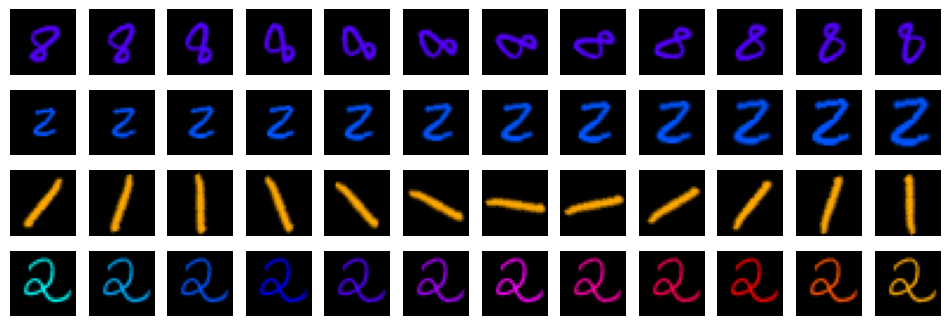

In [66]:
inp = iter(trainer.train_loader).next()[0]

lim = model.n_obs
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(inp))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[3][k].axis('off')

In [67]:
#model.warmup = 0
trainer.train()

Model passed sanity check !

Created dummy_output_dir/VAE_IAF_training_2022-10-25_17-21-58. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 1/10:   0%|          | 0/94 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.2315
Eval loss: 44.2393
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 2/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 2/10:   0%|          | 0/94 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.1602
Eval loss: 40.3162
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 3/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 3/10:   0%|          | 0/94 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.5333
Eval loss: 36.8969
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 4/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 4/10:   0%|          | 0/94 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.7779
Eval loss: 34.6706
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 5/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 5/10:   0%|          | 0/94 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.662
Eval loss: 32.6778
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 6/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 6/10:   0%|          | 0/94 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


--------------------------------------------------------------------------
Train loss: 32.0375
Eval loss: 31.547
--------------------------------------------------------------------------


Training of epoch 7/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 7/10:   0%|          | 0/94 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.1562
Eval loss: 30.8642
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 8/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 8/10:   0%|          | 0/94 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.5957
Eval loss: 30.4268
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 9/10:   0%|          | 0/375 [00:00<?, ?batch/s]

Eval of epoch 9/10:   0%|          | 0/94 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.1899
Eval loss: 30.1378
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 10/10:   0%|          | 0/375 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [68]:
#from pythae.models import LVAE_IAF
#model = LVAE_IAF.load_from_folder('dummy_output_dir/VAE_IAF_training_2022-10-25_13-40-22/checkpoint_epoch_69').cuda()
model.model_config.reconstruction_loss = 'bce'
model_rec = model

In [71]:
inp = iter(trainer.eval_loader).next()
model_rec.get_nll(inp.data.reshape(-1, 3, 28, 28))

-254.6768033603827

In [50]:
torch.__version__

'1.12.0+cu102'

ValueError: Expected value argument (Tensor of shape (10, 12, 3, 28, 28)) to be within the support (Boolean()) of the distribution Bernoulli(probs: torch.Size([10, 12, 3, 28, 28])), but found invalid values:
tensor([[[[[9.7952e-01, 5.0881e-02, 9.4285e-02,  ..., 8.3987e-01,
            4.1178e-01, 4.7014e-01],
           [2.7121e-01, 5.8976e-01, 4.5321e-01,  ..., 6.0975e-01,
            4.2156e-01, 2.7305e-01],
           [8.3469e-01, 2.7965e-01, 4.7710e-01,  ..., 6.7749e-02,
            7.1638e-01, 4.1829e-01],
           ...,
           [6.7284e-01, 1.0591e-01, 4.3291e-01,  ..., 7.6849e-01,
            6.5368e-01, 7.0504e-01],
           [9.9805e-01, 3.2350e-01, 6.5299e-01,  ..., 8.5780e-01,
            4.7559e-01, 8.8704e-01],
           [9.2384e-01, 4.3104e-01, 7.0992e-01,  ..., 4.1815e-01,
            3.4741e-01, 4.2199e-01]],

          [[2.1811e-01, 2.4447e-01, 5.5288e-01,  ..., 2.1712e-01,
            9.1121e-01, 6.3726e-01],
           [2.0590e-01, 5.2278e-01, 6.4204e-01,  ..., 7.9093e-01,
            8.4502e-01, 4.3261e-01],
           [8.3717e-01, 3.6941e-01, 7.8360e-01,  ..., 7.4915e-02,
            4.9196e-01, 4.8986e-01],
           ...,
           [1.4314e-01, 9.0577e-01, 6.5477e-01,  ..., 7.0480e-02,
            5.6941e-02, 2.5497e-01],
           [8.1396e-01, 5.3945e-01, 5.6596e-01,  ..., 5.7975e-02,
            6.9700e-01, 3.0063e-01],
           [3.6145e-01, 4.3283e-01, 4.3434e-01,  ..., 6.4743e-01,
            2.3738e-02, 4.9666e-01]],

          [[9.9994e-01, 5.1033e-01, 3.4182e-01,  ..., 8.7226e-01,
            4.9003e-01, 7.5578e-01],
           [8.2226e-01, 6.7200e-01, 9.3571e-01,  ..., 1.4131e-01,
            4.4825e-01, 5.9888e-01],
           [9.0337e-01, 8.8658e-01, 7.2202e-01,  ..., 3.8760e-01,
            8.0504e-01, 5.2259e-01],
           ...,
           [5.3263e-01, 7.3310e-01, 2.4165e-01,  ..., 3.5075e-01,
            3.2887e-01, 2.6817e-01],
           [9.4720e-01, 3.0556e-01, 5.0778e-01,  ..., 8.3243e-01,
            1.7135e-01, 7.6965e-01],
           [5.7817e-01, 1.3170e-01, 6.3982e-01,  ..., 5.1239e-01,
            6.9294e-01, 4.8485e-01]]],


         [[[7.9536e-01, 2.8315e-01, 4.3779e-01,  ..., 9.6491e-01,
            5.6266e-01, 9.7905e-02],
           [7.5167e-01, 9.8203e-01, 7.4008e-01,  ..., 4.6765e-01,
            2.1668e-02, 5.7437e-01],
           [5.7531e-01, 1.7372e-01, 2.7008e-01,  ..., 8.5475e-01,
            5.0439e-01, 7.3995e-01],
           ...,
           [6.6391e-01, 1.3790e-01, 6.0050e-01,  ..., 6.1577e-01,
            8.2177e-01, 9.1422e-01],
           [1.6026e-01, 1.4126e-01, 8.7884e-01,  ..., 9.3232e-01,
            1.0406e-01, 8.6065e-02],
           [1.8733e-01, 9.1471e-01, 4.1915e-01,  ..., 9.7330e-01,
            4.3208e-01, 1.9607e-02]],

          [[3.5727e-01, 2.4146e-01, 1.2146e-01,  ..., 9.3975e-01,
            9.9371e-01, 7.8891e-03],
           [2.7490e-03, 8.4142e-01, 1.0066e-01,  ..., 2.9431e-01,
            5.3054e-01, 5.9323e-01],
           [5.3240e-01, 8.2557e-01, 6.9244e-01,  ..., 6.5460e-01,
            8.2951e-02, 1.8619e-02],
           ...,
           [6.9317e-02, 4.6999e-01, 3.6040e-01,  ..., 9.4627e-01,
            8.8753e-02, 8.6608e-01],
           [2.9547e-01, 8.2973e-01, 4.9060e-01,  ..., 7.6644e-01,
            7.0818e-01, 6.7528e-02],
           [3.3260e-01, 2.8145e-01, 3.9861e-01,  ..., 5.0082e-01,
            2.1975e-01, 1.3020e-01]],

          [[2.0087e-01, 3.5007e-01, 3.7627e-01,  ..., 5.5488e-01,
            4.9626e-01, 1.1732e-01],
           [3.1059e-02, 9.3792e-01, 3.7624e-01,  ..., 1.2479e-01,
            3.0345e-01, 8.2260e-01],
           [9.8495e-01, 3.6221e-01, 3.1427e-01,  ..., 4.4539e-01,
            7.0469e-01, 2.3631e-01],
           ...,
           [8.2821e-01, 4.7879e-01, 6.5247e-02,  ..., 3.3351e-01,
            1.0636e-01, 6.1917e-01],
           [5.9160e-01, 4.4745e-01, 1.8253e-01,  ..., 1.6250e-01,
            8.6629e-01, 5.1624e-01],
           [5.0283e-01, 2.1561e-01, 6.7788e-01,  ..., 7.8581e-02,
            5.6015e-01, 5.5206e-01]]],


         [[[6.1088e-01, 3.9632e-01, 9.8848e-01,  ..., 4.9106e-01,
            9.1093e-01, 7.1618e-01],
           [7.1130e-01, 3.3225e-01, 5.0794e-01,  ..., 8.3479e-01,
            4.4863e-01, 4.6820e-01],
           [9.6943e-02, 8.9142e-01, 6.9180e-01,  ..., 8.9766e-01,
            9.0343e-01, 8.1473e-01],
           ...,
           [2.5845e-01, 6.1399e-03, 2.9898e-02,  ..., 7.2484e-01,
            5.9478e-01, 9.7213e-01],
           [8.1857e-01, 4.0287e-01, 8.6440e-01,  ..., 4.3219e-01,
            1.2584e-01, 2.3350e-02],
           [7.8781e-01, 4.0786e-01, 9.2333e-01,  ..., 8.1573e-01,
            6.1891e-01, 2.6189e-01]],

          [[3.0566e-01, 5.2501e-01, 8.3328e-01,  ..., 2.0547e-02,
            1.4219e-01, 2.4659e-01],
           [1.8286e-01, 4.9909e-01, 6.7229e-02,  ..., 7.9315e-01,
            3.9109e-01, 3.2811e-01],
           [9.7643e-01, 4.4957e-01, 7.1323e-01,  ..., 3.1326e-01,
            7.6297e-01, 1.8305e-01],
           ...,
           [2.5195e-01, 5.0972e-01, 9.1317e-01,  ..., 5.3230e-01,
            4.4412e-01, 5.4300e-01],
           [9.2957e-01, 2.1864e-01, 6.1332e-01,  ..., 9.5131e-01,
            2.1320e-01, 8.5551e-04],
           [5.6382e-02, 4.3381e-01, 4.8719e-01,  ..., 9.4516e-01,
            3.5233e-01, 2.8771e-01]],

          [[1.2424e-01, 4.8373e-01, 2.0936e-01,  ..., 6.9698e-01,
            5.3417e-01, 2.8296e-01],
           [8.3592e-01, 9.6478e-01, 4.2052e-01,  ..., 1.5035e-01,
            4.2606e-02, 9.0155e-01],
           [1.7084e-01, 9.1357e-01, 6.4404e-03,  ..., 2.9741e-01,
            6.5771e-01, 1.2391e-03],
           ...,
           [8.8260e-01, 3.0666e-01, 1.3916e-01,  ..., 1.6426e-01,
            5.0347e-01, 5.2976e-01],
           [4.9304e-01, 9.7507e-01, 8.2639e-01,  ..., 1.9111e-01,
            4.5094e-01, 8.1095e-01],
           [8.9733e-01, 5.2019e-01, 5.2718e-01,  ..., 4.7108e-01,
            8.6078e-01, 4.4396e-01]]],


         ...,


         [[[6.6959e-01, 4.5934e-02, 1.4015e-01,  ..., 9.7526e-01,
            4.0725e-01, 5.8510e-02],
           [5.3158e-01, 7.1285e-01, 9.2684e-01,  ..., 2.7177e-01,
            3.9296e-01, 2.3092e-01],
           [7.2327e-01, 2.1337e-01, 3.4919e-02,  ..., 3.5027e-02,
            2.5854e-01, 8.5523e-01],
           ...,
           [8.1121e-01, 8.2287e-01, 1.1423e-01,  ..., 7.3867e-01,
            6.5047e-01, 4.4638e-01],
           [2.5827e-01, 8.3255e-01, 7.2726e-01,  ..., 6.8330e-01,
            1.1400e-01, 5.3711e-01],
           [3.7507e-01, 7.0266e-01, 5.9980e-02,  ..., 3.2518e-01,
            8.6264e-01, 1.6642e-01]],

          [[8.3010e-01, 2.3556e-01, 4.2812e-01,  ..., 9.2408e-01,
            1.3259e-01, 2.1011e-01],
           [8.8009e-01, 7.8448e-01, 9.1426e-01,  ..., 4.3084e-01,
            1.8020e-02, 1.0965e-01],
           [6.1078e-01, 8.6161e-01, 4.1562e-01,  ..., 3.6118e-01,
            9.0155e-01, 8.3592e-01],
           ...,
           [5.9651e-01, 2.8784e-01, 1.9960e-01,  ..., 4.6000e-01,
            6.5255e-01, 1.9580e-01],
           [2.1479e-01, 2.1043e-01, 5.8789e-01,  ..., 5.1970e-01,
            5.5562e-01, 2.0641e-02],
           [4.8566e-01, 9.0318e-01, 2.1701e-01,  ..., 8.7540e-01,
            6.9909e-01, 1.3229e-01]],

          [[5.3421e-01, 4.7964e-01, 4.6735e-01,  ..., 7.7385e-01,
            9.4386e-01, 7.6072e-01],
           [1.4325e-02, 3.5903e-01, 2.6497e-01,  ..., 9.9945e-01,
            1.6897e-01, 3.5862e-01],
           [8.2649e-01, 3.8691e-01, 1.7764e-01,  ..., 7.8965e-01,
            3.6911e-02, 8.9655e-01],
           ...,
           [1.9453e-01, 4.7156e-01, 6.9798e-01,  ..., 2.4610e-01,
            1.8177e-01, 9.4944e-01],
           [2.1345e-01, 4.0800e-01, 8.6827e-01,  ..., 4.3373e-01,
            3.8824e-01, 7.9970e-01],
           [2.6767e-01, 5.5734e-01, 1.4549e-01,  ..., 4.9092e-01,
            8.7031e-01, 9.3007e-01]]],


         [[[9.2321e-01, 5.3177e-01, 3.2883e-01,  ..., 3.1639e-01,
            2.6365e-02, 6.7017e-01],
           [1.6172e-01, 4.7421e-01, 2.4141e-01,  ..., 6.0812e-01,
            6.8216e-01, 1.7435e-01],
           [6.5845e-02, 4.0051e-01, 5.9399e-01,  ..., 1.6225e-01,
            9.3612e-01, 2.4248e-02],
           ...,
           [7.3916e-01, 7.6285e-01, 5.9117e-01,  ..., 4.3260e-01,
            6.8409e-01, 7.4120e-01],
           [9.9181e-01, 9.4993e-01, 6.7090e-01,  ..., 1.1015e-01,
            8.0466e-01, 9.1191e-01],
           [2.8589e-01, 1.2155e-01, 8.1426e-01,  ..., 5.1547e-01,
            2.3850e-02, 5.3395e-01]],

          [[4.4838e-01, 5.6490e-01, 7.7414e-01,  ..., 9.1321e-01,
            3.7944e-01, 7.4858e-01],
           [4.7750e-01, 8.7310e-01, 5.4662e-01,  ..., 7.8023e-01,
            5.5352e-01, 7.3145e-01],
           [3.5428e-01, 6.6007e-01, 4.1428e-01,  ..., 3.5490e-01,
            6.9174e-01, 8.6955e-01],
           ...,
           [1.4688e-01, 5.5078e-01, 3.9628e-01,  ..., 7.6740e-01,
            3.5565e-01, 4.6379e-01],
           [6.7527e-01, 7.3336e-01, 8.1946e-01,  ..., 1.1917e-01,
            8.3872e-01, 3.0798e-04],
           [2.4660e-01, 3.5851e-01, 2.1076e-02,  ..., 4.5582e-01,
            1.0134e-01, 5.3842e-01]],

          [[7.8411e-01, 3.2681e-01, 9.4227e-01,  ..., 1.3879e-02,
            4.9461e-01, 3.0539e-01],
           [6.2079e-02, 8.8731e-01, 7.1461e-01,  ..., 9.8698e-01,
            8.1243e-01, 9.5979e-01],
           [6.4146e-01, 2.3607e-01, 5.5085e-02,  ..., 1.9748e-01,
            2.4416e-01, 7.1599e-01],
           ...,
           [9.8294e-02, 2.6778e-01, 6.0274e-01,  ..., 6.3410e-01,
            4.1305e-01, 5.2077e-01],
           [6.8273e-01, 1.9537e-01, 2.8431e-01,  ..., 5.8571e-01,
            6.5249e-01, 6.0058e-01],
           [9.2095e-02, 6.3586e-01, 8.4354e-01,  ..., 1.9946e-01,
            8.9125e-01, 2.3087e-01]]],


         [[[9.3956e-01, 6.7767e-01, 8.9490e-01,  ..., 8.0666e-01,
            6.2089e-01, 4.9027e-01],
           [2.3741e-02, 9.7987e-01, 5.7818e-01,  ..., 8.0487e-01,
            1.6614e-01, 8.4381e-01],
           [8.4024e-01, 5.1809e-01, 5.0387e-01,  ..., 6.6171e-01,
            4.3617e-01, 9.9627e-01],
           ...,
           [7.1036e-01, 8.0171e-01, 5.0848e-01,  ..., 3.0740e-01,
            8.1225e-01, 8.0079e-01],
           [3.4178e-01, 5.5431e-01, 9.6622e-01,  ..., 9.8524e-01,
            4.5983e-01, 7.1817e-01],
           [9.2403e-02, 1.2886e-01, 4.6276e-01,  ..., 8.0360e-02,
            4.9193e-01, 1.3279e-01]],

          [[9.2232e-02, 6.8208e-01, 8.6327e-01,  ..., 9.1750e-01,
            7.1741e-01, 7.2980e-01],
           [7.9073e-01, 2.8354e-01, 4.5988e-01,  ..., 6.5497e-01,
            1.8731e-01, 5.2388e-01],
           [8.5988e-01, 7.9907e-01, 1.4404e-01,  ..., 4.2081e-01,
            8.7304e-02, 2.3524e-01],
           ...,
           [4.9218e-01, 8.7806e-01, 4.7688e-01,  ..., 1.7265e-02,
            2.4568e-01, 3.2992e-01],
           [9.2498e-01, 2.1235e-01, 2.6190e-01,  ..., 7.1983e-01,
            9.8120e-01, 8.8058e-01],
           [9.2498e-02, 6.3317e-01, 3.9827e-02,  ..., 6.7425e-01,
            4.7465e-01, 7.4221e-01]],

          [[4.0414e-01, 3.2180e-01, 6.6144e-01,  ..., 7.6076e-01,
            8.1102e-01, 4.4324e-01],
           [3.2053e-01, 1.6297e-01, 5.3033e-02,  ..., 5.3625e-01,
            7.6452e-02, 6.4314e-01],
           [5.4590e-01, 1.7917e-01, 6.9850e-01,  ..., 3.8428e-02,
            9.1497e-01, 5.7351e-01],
           ...,
           [9.5321e-01, 8.0812e-01, 8.6853e-01,  ..., 1.0212e-01,
            8.5760e-01, 2.0064e-01],
           [8.6409e-01, 1.1522e-01, 3.1065e-01,  ..., 6.1121e-01,
            1.2664e-01, 5.5207e-01],
           [8.3629e-01, 9.5416e-01, 6.9178e-01,  ..., 7.9662e-01,
            3.7556e-01, 7.9975e-01]]]],



        [[[[5.0013e-01, 8.5520e-01, 8.7530e-01,  ..., 9.4162e-01,
            7.2607e-01, 3.5441e-01],
           [3.6767e-01, 9.7388e-01, 1.1093e-01,  ..., 1.2848e-01,
            3.9678e-01, 2.2124e-01],
           [3.5301e-01, 7.0590e-01, 9.8836e-01,  ..., 9.6803e-01,
            4.7268e-01, 3.0383e-01],
           ...,
           [2.4391e-01, 9.1763e-01, 5.1832e-01,  ..., 5.5156e-02,
            8.1148e-02, 9.3441e-01],
           [7.7427e-01, 1.8936e-03, 6.1584e-01,  ..., 8.5225e-01,
            5.7218e-01, 9.3566e-01],
           [7.3671e-02, 7.4152e-01, 7.2136e-01,  ..., 8.4553e-02,
            6.7685e-02, 7.4287e-01]],

          [[6.6589e-01, 2.4241e-01, 1.7702e-01,  ..., 7.7747e-01,
            9.9580e-01, 4.8728e-01],
           [5.0000e-02, 8.9732e-01, 4.8788e-01,  ..., 4.1475e-02,
            2.6989e-02, 7.4410e-01],
           [4.7099e-01, 2.4855e-01, 5.6899e-01,  ..., 8.1605e-04,
            6.0581e-01, 3.0795e-01],
           ...,
           [2.8798e-01, 8.3933e-01, 4.6378e-01,  ..., 9.3305e-01,
            8.8182e-01, 8.0670e-01],
           [1.8672e-01, 9.7760e-01, 7.7452e-02,  ..., 3.9044e-01,
            7.2163e-01, 8.3673e-01],
           [9.9981e-01, 6.9677e-01, 8.6452e-01,  ..., 9.3150e-01,
            8.2273e-01, 8.5200e-01]],

          [[3.6528e-01, 8.6899e-01, 3.3527e-01,  ..., 4.1393e-01,
            5.7087e-01, 2.9676e-01],
           [7.1121e-01, 6.4752e-02, 9.5968e-01,  ..., 4.3108e-02,
            6.1514e-01, 8.3183e-01],
           [8.2625e-01, 4.1261e-01, 4.2099e-01,  ..., 1.3001e-01,
            1.2229e-01, 8.5081e-01],
           ...,
           [4.0357e-01, 5.6785e-01, 7.4831e-01,  ..., 4.8247e-01,
            3.0815e-01, 6.2346e-01],
           [8.3465e-01, 5.7656e-01, 3.1900e-01,  ..., 6.6758e-01,
            5.6582e-01, 7.7187e-01],
           [2.4705e-01, 7.3929e-01, 9.7412e-01,  ..., 4.0250e-01,
            1.1874e-01, 6.4967e-01]]],


         [[[8.5188e-01, 5.6782e-01, 7.7164e-01,  ..., 5.4254e-02,
            4.8884e-01, 5.2732e-01],
           [6.1304e-01, 9.3251e-01, 9.8377e-01,  ..., 9.5497e-02,
            6.8703e-01, 1.6420e-01],
           [1.5747e-01, 7.6468e-01, 5.8700e-01,  ..., 6.5985e-01,
            1.7577e-01, 6.9790e-02],
           ...,
           [2.0257e-01, 7.2316e-01, 4.2068e-01,  ..., 4.6519e-01,
            5.5151e-01, 5.6758e-01],
           [4.3639e-02, 4.1195e-01, 4.4508e-01,  ..., 6.7091e-01,
            5.6300e-01, 1.5387e-01],
           [7.7551e-01, 7.9714e-01, 1.6673e-01,  ..., 5.9534e-01,
            7.7247e-01, 9.9993e-01]],

          [[1.7608e-01, 5.1313e-01, 3.2932e-01,  ..., 8.5548e-02,
            1.6950e-01, 3.9759e-02],
           [3.8038e-01, 8.3940e-01, 6.4616e-01,  ..., 2.4597e-01,
            5.4273e-01, 8.2870e-01],
           [5.3111e-01, 9.7609e-01, 5.0294e-02,  ..., 6.8186e-01,
            1.4700e-01, 4.4454e-01],
           ...,
           [5.9631e-01, 8.2122e-01, 5.7736e-02,  ..., 7.5295e-01,
            6.4353e-01, 2.2745e-01],
           [5.5155e-01, 4.1843e-01, 7.6487e-01,  ..., 3.4534e-01,
            2.3792e-01, 6.7960e-01],
           [2.0123e-01, 6.8617e-01, 7.9633e-01,  ..., 6.4952e-01,
            3.9972e-01, 4.4799e-01]],

          [[1.3495e-01, 8.1012e-01, 4.1062e-01,  ..., 7.5012e-02,
            4.6802e-01, 8.0028e-01],
           [2.7295e-02, 7.2324e-01, 8.8358e-01,  ..., 5.7099e-01,
            5.6244e-01, 1.6012e-01],
           [5.6984e-01, 9.1316e-01, 8.3146e-01,  ..., 5.6506e-01,
            1.4724e-01, 3.8081e-01],
           ...,
           [8.5817e-01, 7.5663e-01, 4.5510e-01,  ..., 5.1379e-02,
            1.3127e-01, 3.7883e-01],
           [7.8546e-01, 3.5342e-01, 5.4144e-01,  ..., 8.7311e-01,
            3.1114e-01, 5.0786e-01],
           [5.7227e-01, 1.3195e-01, 2.8581e-01,  ..., 9.2378e-01,
            6.6750e-01, 4.1790e-01]]],


         [[[2.0218e-02, 7.1809e-01, 2.0557e-01,  ..., 3.5651e-01,
            2.1055e-01, 4.9161e-01],
           [5.5670e-01, 8.9263e-01, 6.7290e-01,  ..., 8.1631e-01,
            9.1880e-01, 7.0734e-01],
           [7.6601e-01, 2.4167e-01, 6.5649e-01,  ..., 4.6313e-02,
            4.8191e-01, 6.2180e-01],
           ...,
           [5.3839e-01, 1.3575e-01, 7.4024e-01,  ..., 6.8918e-01,
            9.1102e-01, 2.1763e-01],
           [1.6814e-01, 8.8889e-01, 3.7534e-02,  ..., 3.7047e-01,
            1.4565e-01, 9.3891e-01],
           [8.5433e-01, 7.9278e-01, 2.9496e-01,  ..., 8.3624e-01,
            9.2734e-01, 8.1145e-02]],

          [[1.1282e-01, 9.6700e-01, 5.8101e-01,  ..., 3.4957e-01,
            4.8411e-02, 8.0235e-01],
           [8.7480e-01, 3.1238e-01, 3.2431e-01,  ..., 4.6737e-01,
            9.6535e-01, 1.7074e-01],
           [7.7415e-02, 4.7667e-01, 4.3330e-01,  ..., 3.6655e-01,
            6.2731e-01, 9.3687e-01],
           ...,
           [2.5593e-01, 7.2342e-01, 7.0487e-01,  ..., 9.3782e-01,
            9.7265e-01, 8.6101e-01],
           [8.1422e-01, 6.6725e-01, 6.2998e-01,  ..., 9.6585e-01,
            6.8271e-01, 1.7053e-01],
           [1.8695e-01, 6.7755e-02, 3.0074e-01,  ..., 8.1799e-01,
            6.7228e-01, 7.8934e-02]],

          [[2.5944e-01, 6.5355e-01, 1.2947e-01,  ..., 4.4028e-01,
            6.6686e-01, 3.8287e-01],
           [9.3648e-01, 5.5759e-01, 2.6853e-01,  ..., 4.7522e-01,
            6.5140e-01, 7.8024e-02],
           [2.0634e-01, 3.8753e-01, 5.1891e-01,  ..., 7.5462e-01,
            9.7512e-01, 5.9335e-01],
           ...,
           [4.1929e-01, 7.6380e-01, 7.3601e-02,  ..., 1.9829e-01,
            9.5876e-02, 3.0280e-01],
           [7.3077e-01, 2.4879e-01, 2.2968e-01,  ..., 6.8555e-01,
            2.2426e-01, 5.4202e-01],
           [1.3302e-01, 1.4548e-01, 8.6837e-02,  ..., 7.0831e-01,
            8.5925e-01, 6.9449e-01]]],


         ...,


         [[[8.7367e-01, 8.3046e-01, 5.3171e-01,  ..., 9.5929e-01,
            8.6025e-01, 4.5944e-01],
           [1.8168e-01, 9.1536e-01, 1.8589e-01,  ..., 3.4184e-01,
            6.1053e-01, 5.4459e-01],
           [6.6694e-01, 6.1704e-01, 8.8002e-01,  ..., 2.5243e-01,
            3.3920e-01, 3.2199e-01],
           ...,
           [6.9694e-01, 1.4485e-01, 1.3429e-01,  ..., 3.2779e-01,
            5.1872e-01, 2.9816e-01],
           [9.0816e-01, 4.2898e-01, 6.6832e-01,  ..., 8.3411e-01,
            5.6744e-01, 1.6054e-01],
           [8.8820e-01, 2.7327e-01, 5.3473e-02,  ..., 1.4832e-01,
            5.2333e-01, 4.8880e-01]],

          [[1.4915e-01, 7.8072e-02, 8.4192e-01,  ..., 7.1818e-01,
            8.4322e-01, 4.0457e-01],
           [6.4618e-01, 1.3920e-01, 6.2665e-03,  ..., 4.2459e-01,
            2.7502e-02, 7.2627e-01],
           [7.4094e-01, 7.8316e-02, 3.6610e-01,  ..., 9.3692e-03,
            3.3563e-01, 1.2433e-01],
           ...,
           [4.2148e-01, 7.6527e-01, 6.9799e-01,  ..., 6.1631e-02,
            8.2907e-01, 8.5929e-01],
           [9.5466e-01, 9.7857e-01, 4.3142e-01,  ..., 7.4814e-01,
            1.2263e-01, 4.5521e-01],
           [4.0006e-01, 8.3587e-02, 4.5300e-01,  ..., 3.5093e-01,
            7.9138e-01, 9.2212e-01]],

          [[5.0297e-01, 5.8550e-01, 8.7041e-01,  ..., 7.0801e-01,
            8.3372e-02, 4.2378e-01],
           [4.5351e-01, 8.8756e-01, 4.6121e-02,  ..., 5.3743e-01,
            6.2029e-01, 7.5525e-01],
           [3.9886e-03, 1.1922e-01, 7.8305e-01,  ..., 9.0655e-01,
            6.1958e-01, 7.9279e-01],
           ...,
           [6.3254e-02, 4.9832e-01, 3.1900e-02,  ..., 8.0248e-01,
            3.1959e-01, 9.6740e-01],
           [7.9834e-01, 2.2370e-01, 8.2759e-01,  ..., 2.6058e-02,
            6.0781e-01, 4.0269e-01],
           [4.5071e-01, 1.5868e-01, 4.7173e-01,  ..., 6.6613e-01,
            9.7456e-01, 3.6827e-01]]],


         [[[4.0061e-01, 8.8236e-01, 8.6555e-01,  ..., 9.3260e-01,
            4.9917e-01, 2.8359e-01],
           [6.1720e-01, 5.9264e-01, 8.7919e-01,  ..., 2.6983e-01,
            9.2960e-01, 8.7345e-01],
           [4.3000e-01, 7.2030e-01, 7.2910e-01,  ..., 9.2306e-01,
            7.2646e-01, 4.9563e-01],
           ...,
           [1.2806e-01, 2.5009e-02, 3.2098e-01,  ..., 5.7186e-01,
            3.2124e-01, 6.1305e-01],
           [7.0155e-02, 4.7331e-01, 2.0182e-01,  ..., 7.9223e-01,
            1.5232e-01, 5.0778e-01],
           [6.9418e-01, 7.8416e-01, 8.1175e-01,  ..., 8.9913e-01,
            6.9340e-01, 9.1087e-01]],

          [[5.6393e-01, 1.0381e-01, 4.1641e-01,  ..., 2.8403e-01,
            9.6811e-01, 4.9310e-03],
           [7.4225e-01, 6.6401e-01, 2.1438e-01,  ..., 6.4256e-02,
            9.3186e-01, 9.4171e-01],
           [9.8834e-01, 1.6199e-01, 4.7350e-01,  ..., 3.5136e-01,
            8.0468e-01, 1.1993e-01],
           ...,
           [6.2537e-01, 6.2521e-01, 1.3398e-01,  ..., 4.0129e-01,
            2.5402e-01, 9.2080e-01],
           [3.9488e-01, 2.4919e-01, 7.8343e-01,  ..., 6.3473e-01,
            2.5063e-01, 7.5624e-01],
           [6.3088e-01, 9.7177e-01, 4.0457e-01,  ..., 5.9547e-01,
            9.2422e-01, 1.5696e-01]],

          [[7.5853e-01, 5.2713e-01, 5.6539e-01,  ..., 6.9312e-01,
            7.6108e-01, 1.0016e-01],
           [5.9878e-01, 3.9572e-01, 3.5656e-01,  ..., 5.8601e-01,
            5.0826e-01, 8.6272e-01],
           [1.8528e-01, 9.6074e-03, 6.4890e-01,  ..., 8.3599e-01,
            9.6748e-02, 9.3166e-01],
           ...,
           [2.1140e-01, 5.1795e-01, 4.1541e-02,  ..., 4.0105e-01,
            1.2454e-01, 6.0084e-02],
           [6.5514e-01, 3.5638e-01, 4.2200e-01,  ..., 9.2447e-01,
            4.4396e-01, 9.4523e-01],
           [2.7103e-01, 9.6451e-01, 1.1429e-01,  ..., 8.8449e-01,
            4.8227e-01, 7.9943e-01]]],


         [[[2.7976e-01, 3.7798e-01, 9.3364e-01,  ..., 9.6281e-01,
            4.6373e-01, 1.4793e-01],
           [7.1508e-01, 2.7349e-01, 5.5020e-01,  ..., 2.0607e-01,
            6.4212e-01, 9.7767e-01],
           [7.6709e-01, 4.6573e-01, 8.9764e-01,  ..., 7.0164e-01,
            6.4661e-01, 3.9113e-01],
           ...,
           [1.4299e-01, 8.2399e-01, 6.9704e-01,  ..., 4.0384e-01,
            1.4714e-02, 4.8364e-02],
           [1.3632e-01, 6.5430e-01, 7.4444e-01,  ..., 1.8332e-01,
            4.1970e-01, 6.3387e-01],
           [2.3268e-01, 5.0576e-01, 8.0205e-01,  ..., 8.7899e-01,
            5.4713e-01, 5.0477e-01]],

          [[6.9615e-01, 9.3320e-02, 5.2240e-01,  ..., 3.3607e-01,
            1.0983e-02, 1.8769e-01],
           [2.7972e-01, 9.2694e-01, 3.7953e-02,  ..., 3.7075e-01,
            4.6144e-01, 8.2973e-01],
           [6.8746e-01, 1.1554e-01, 6.0513e-01,  ..., 6.0912e-02,
            2.0247e-01, 4.3027e-01],
           ...,
           [2.6702e-01, 7.8269e-01, 5.3379e-01,  ..., 9.2560e-01,
            8.4856e-01, 2.1969e-01],
           [3.1061e-01, 5.7770e-01, 4.1214e-01,  ..., 5.1484e-01,
            1.6645e-01, 7.5546e-02],
           [2.5739e-01, 2.6539e-01, 7.6475e-01,  ..., 3.1374e-01,
            7.4197e-01, 4.2610e-01]],

          [[4.3607e-01, 2.2206e-01, 9.2988e-01,  ..., 9.7324e-01,
            2.0363e-01, 1.5803e-01],
           [3.6867e-01, 7.6718e-01, 8.1535e-01,  ..., 9.3972e-01,
            3.7255e-01, 6.7479e-01],
           [5.5212e-01, 6.7697e-01, 9.9210e-01,  ..., 6.9142e-01,
            8.1961e-02, 6.0428e-01],
           ...,
           [7.5263e-01, 4.0267e-01, 9.5729e-01,  ..., 5.2361e-02,
            6.5325e-02, 5.0813e-01],
           [3.5844e-03, 6.3270e-01, 8.3482e-01,  ..., 9.7178e-01,
            3.2853e-01, 4.5803e-01],
           [2.9989e-01, 6.6187e-01, 5.5580e-01,  ..., 7.4976e-01,
            6.3902e-01, 2.3829e-01]]]],



        [[[[6.2935e-01, 5.3550e-01, 1.1815e-01,  ..., 5.3602e-01,
            6.3846e-01, 9.7879e-01],
           [6.7403e-01, 5.3982e-01, 8.9945e-01,  ..., 8.7380e-01,
            1.1728e-01, 5.7750e-02],
           [6.4025e-01, 8.5024e-02, 6.9964e-01,  ..., 3.7578e-01,
            3.4005e-01, 7.2384e-01],
           ...,
           [8.2713e-01, 4.1010e-01, 4.6974e-01,  ..., 3.8717e-02,
            1.2488e-01, 6.4147e-01],
           [5.2179e-02, 4.4440e-01, 4.9721e-01,  ..., 5.7566e-01,
            7.8111e-02, 2.5659e-01],
           [4.1014e-02, 3.5056e-01, 3.7480e-01,  ..., 4.8867e-01,
            5.2240e-01, 4.2718e-01]],

          [[8.3777e-01, 4.5156e-01, 8.4835e-01,  ..., 2.4653e-01,
            2.8361e-01, 9.4828e-01],
           [9.5896e-01, 8.6998e-01, 5.2401e-01,  ..., 8.0598e-01,
            3.1536e-01, 4.8718e-02],
           [4.3037e-01, 5.2919e-01, 2.4028e-01,  ..., 7.9010e-02,
            5.3349e-01, 7.3344e-04],
           ...,
           [8.0317e-02, 1.8866e-01, 2.6940e-01,  ..., 3.6308e-01,
            1.5983e-01, 4.6749e-01],
           [4.5456e-01, 9.1426e-01, 9.9766e-01,  ..., 2.0979e-01,
            6.9676e-01, 7.4385e-01],
           [2.8974e-01, 2.3086e-01, 6.4937e-01,  ..., 3.9457e-01,
            8.9297e-01, 7.5750e-01]],

          [[9.8926e-01, 3.5156e-02, 6.7498e-01,  ..., 1.4553e-01,
            7.2525e-01, 7.8382e-01],
           [7.9016e-01, 1.2797e-01, 6.9321e-01,  ..., 3.2166e-01,
            6.5534e-01, 9.2503e-01],
           [6.5181e-01, 4.3193e-02, 4.6768e-01,  ..., 5.9956e-01,
            1.7820e-01, 1.8042e-01],
           ...,
           [6.8234e-01, 7.2425e-01, 6.0489e-01,  ..., 8.6949e-01,
            1.5976e-01, 6.5933e-01],
           [3.6309e-01, 9.8124e-02, 2.6246e-01,  ..., 6.2230e-01,
            3.5811e-01, 6.5456e-01],
           [2.9041e-01, 9.6892e-01, 6.3105e-03,  ..., 5.9992e-01,
            7.2260e-01, 8.8243e-01]]],


         [[[9.2643e-01, 5.9185e-01, 1.0075e-01,  ..., 3.9953e-01,
            7.0208e-01, 2.5835e-01],
           [2.7544e-01, 8.9754e-01, 9.5714e-01,  ..., 3.4513e-01,
            3.0754e-03, 4.8963e-01],
           [9.7061e-01, 5.7350e-01, 3.1839e-01,  ..., 8.0240e-01,
            1.6280e-01, 3.0006e-01],
           ...,
           [2.7909e-01, 9.9093e-01, 3.3333e-01,  ..., 8.6975e-01,
            1.0561e-01, 4.8466e-01],
           [2.1817e-01, 2.2036e-01, 7.5410e-01,  ..., 8.2137e-01,
            4.7200e-01, 3.7664e-01],
           [8.7192e-01, 3.6234e-01, 3.0998e-01,  ..., 3.8377e-01,
            7.5396e-01, 1.6001e-01]],

          [[4.8921e-01, 3.7124e-01, 1.9263e-01,  ..., 8.6521e-01,
            9.7424e-01, 7.7688e-01],
           [2.5340e-01, 6.6412e-02, 2.3518e-02,  ..., 3.1535e-01,
            4.7164e-01, 2.2052e-01],
           [9.1003e-01, 1.8492e-01, 4.1218e-01,  ..., 5.0872e-01,
            5.2703e-01, 5.3961e-01],
           ...,
           [9.0029e-01, 4.0552e-01, 1.6909e-01,  ..., 5.0334e-01,
            4.4566e-01, 6.9824e-01],
           [2.6130e-01, 9.1416e-01, 9.8276e-02,  ..., 1.9647e-01,
            8.9413e-01, 3.7403e-02],
           [4.9267e-02, 7.7782e-01, 1.0037e-01,  ..., 3.7929e-01,
            8.6476e-01, 6.9809e-01]],

          [[4.7771e-01, 6.3100e-01, 6.1054e-01,  ..., 2.1066e-02,
            1.7065e-01, 1.5532e-01],
           [9.4847e-01, 2.7104e-02, 5.1027e-01,  ..., 6.3528e-01,
            2.4226e-01, 5.5668e-01],
           [7.3601e-01, 9.3303e-02, 8.0303e-01,  ..., 4.3533e-01,
            9.7038e-01, 6.8999e-01],
           ...,
           [1.9923e-01, 8.7520e-01, 1.7788e-01,  ..., 7.9516e-01,
            1.8737e-01, 6.2387e-02],
           [4.5511e-01, 3.1964e-01, 8.3749e-01,  ..., 5.5442e-01,
            8.3224e-01, 5.3231e-02],
           [2.1397e-01, 8.6540e-01, 8.0511e-01,  ..., 4.5444e-01,
            3.6816e-01, 3.0948e-01]]],


         [[[1.6223e-01, 5.2006e-01, 8.0487e-01,  ..., 6.2677e-01,
            8.7619e-01, 8.6202e-01],
           [5.6564e-01, 5.6523e-01, 2.0775e-01,  ..., 8.1788e-01,
            9.4551e-04, 7.6090e-01],
           [9.7291e-01, 7.9387e-01, 7.2546e-01,  ..., 9.3781e-01,
            4.4156e-01, 1.2583e-01],
           ...,
           [7.8285e-01, 7.2023e-01, 4.9282e-01,  ..., 1.7786e-01,
            4.6288e-01, 6.7061e-01],
           [7.2515e-01, 8.7612e-01, 8.6822e-01,  ..., 7.0583e-01,
            9.4691e-01, 4.9929e-01],
           [1.6815e-01, 9.0412e-01, 7.4968e-01,  ..., 7.0367e-01,
            5.1717e-01, 7.0302e-02]],

          [[2.8676e-01, 7.7382e-01, 9.6791e-01,  ..., 9.1625e-01,
            3.3762e-01, 8.5048e-02],
           [1.7854e-01, 8.3461e-03, 1.4599e-01,  ..., 6.9617e-01,
            3.8609e-01, 3.2001e-01],
           [7.1266e-01, 3.5725e-01, 1.4939e-01,  ..., 4.8772e-01,
            3.0023e-01, 9.1414e-01],
           ...,
           [4.8417e-01, 9.5036e-01, 2.8321e-01,  ..., 4.2593e-01,
            8.3298e-01, 9.8066e-01],
           [9.3826e-01, 1.6211e-01, 9.3468e-01,  ..., 6.5643e-01,
            6.8351e-01, 2.5076e-01],
           [8.4245e-01, 4.3805e-01, 1.1407e-01,  ..., 5.3936e-01,
            1.9986e-01, 8.5035e-01]],

          [[7.2570e-01, 1.5799e-01, 7.7154e-01,  ..., 8.4657e-01,
            7.6988e-01, 2.7280e-01],
           [6.6696e-01, 4.1681e-01, 9.0842e-01,  ..., 5.7382e-01,
            6.0802e-01, 5.1883e-01],
           [3.2385e-01, 7.6976e-01, 7.0698e-01,  ..., 2.7088e-01,
            4.4857e-01, 5.6824e-01],
           ...,
           [2.3359e-01, 6.4535e-01, 5.7968e-01,  ..., 7.2159e-01,
            1.5763e-01, 7.6522e-01],
           [5.5802e-01, 8.4852e-01, 7.5038e-01,  ..., 7.3107e-01,
            9.8636e-01, 4.5357e-01],
           [1.1135e-01, 7.8928e-01, 8.6274e-01,  ..., 8.1725e-01,
            9.0923e-01, 1.6180e-01]]],


         ...,


         [[[1.9428e-02, 1.4296e-01, 2.3606e-01,  ..., 9.6787e-01,
            1.5897e-01, 7.6388e-01],
           [4.9217e-01, 3.1445e-01, 6.7523e-01,  ..., 9.6766e-01,
            7.7100e-01, 4.2638e-01],
           [2.2450e-01, 7.8858e-01, 5.5443e-01,  ..., 2.5035e-01,
            2.9649e-01, 8.6413e-01],
           ...,
           [7.3319e-01, 8.4684e-01, 2.2739e-01,  ..., 7.4232e-01,
            5.2391e-01, 1.3070e-02],
           [4.2148e-01, 1.7009e-01, 4.9308e-01,  ..., 2.5017e-01,
            6.6352e-01, 4.5532e-01],
           [4.2145e-01, 8.3669e-01, 6.0746e-01,  ..., 9.3346e-01,
            1.6443e-02, 5.5834e-01]],

          [[1.6000e-01, 2.4669e-01, 3.1599e-01,  ..., 2.4938e-01,
            5.0013e-01, 1.0683e-02],
           [5.0823e-01, 3.4743e-01, 3.7981e-01,  ..., 5.1317e-02,
            8.2470e-01, 9.4584e-01],
           [2.9958e-01, 1.9816e-01, 5.2985e-01,  ..., 9.9986e-01,
            4.2036e-01, 5.0816e-01],
           ...,
           [9.8085e-01, 6.1564e-01, 1.8759e-01,  ..., 4.0231e-01,
            1.4618e-01, 8.6911e-01],
           [5.3931e-01, 5.5129e-02, 5.9655e-01,  ..., 4.3557e-01,
            8.7484e-01, 2.8224e-01],
           [8.3371e-01, 8.4219e-02, 5.3871e-01,  ..., 4.1406e-01,
            8.2425e-01, 2.0885e-01]],

          [[7.7790e-01, 8.3528e-01, 1.7639e-01,  ..., 8.2753e-01,
            4.0198e-01, 2.5670e-01],
           [7.5156e-01, 1.5186e-01, 2.3841e-01,  ..., 8.0306e-01,
            1.5545e-01, 4.1660e-01],
           [3.9933e-01, 5.5955e-01, 2.6960e-01,  ..., 2.9030e-01,
            6.9692e-01, 5.9567e-01],
           ...,
           [5.7314e-02, 9.8507e-01, 2.9462e-01,  ..., 8.0626e-01,
            7.1721e-01, 4.3159e-01],
           [4.7184e-01, 6.8060e-01, 1.1280e-02,  ..., 4.2499e-01,
            3.5525e-01, 1.8656e-01],
           [9.3524e-01, 8.4326e-01, 9.5580e-02,  ..., 6.1447e-01,
            3.9476e-01, 3.8200e-01]]],


         [[[8.7758e-01, 2.5076e-02, 6.3388e-02,  ..., 8.0828e-02,
            2.9567e-01, 1.6812e-01],
           [6.8627e-01, 4.3432e-02, 8.5430e-01,  ..., 4.2224e-01,
            4.9727e-02, 1.3239e-01],
           [5.7971e-01, 3.0191e-01, 6.6497e-01,  ..., 5.9316e-01,
            6.6120e-01, 5.4172e-01],
           ...,
           [1.6809e-01, 2.1348e-01, 5.7418e-01,  ..., 1.9712e-01,
            4.5172e-01, 5.4435e-01],
           [3.5154e-01, 1.7366e-01, 8.1460e-01,  ..., 3.5885e-01,
            9.2158e-01, 7.5548e-01],
           [2.6358e-01, 1.1904e-01, 9.9162e-01,  ..., 1.4398e-01,
            2.3331e-01, 5.1009e-01]],

          [[1.2482e-01, 1.9594e-01, 3.6282e-01,  ..., 6.0920e-01,
            1.8306e-01, 5.2301e-01],
           [3.8996e-01, 1.7996e-01, 9.9823e-01,  ..., 3.4361e-01,
            5.1990e-01, 3.3249e-02],
           [3.2784e-01, 2.9964e-01, 8.2548e-01,  ..., 6.6713e-01,
            9.4934e-01, 2.3535e-03],
           ...,
           [1.2593e-01, 4.3411e-01, 9.2098e-01,  ..., 1.1360e-01,
            1.9318e-01, 3.0687e-01],
           [2.4805e-01, 3.8299e-01, 9.2446e-01,  ..., 9.1660e-01,
            8.9755e-01, 5.7881e-01],
           [3.1434e-01, 9.8032e-01, 5.6365e-01,  ..., 4.0583e-01,
            2.0099e-01, 1.6381e-01]],

          [[1.6526e-01, 6.8062e-01, 5.1712e-01,  ..., 1.9907e-01,
            2.7554e-01, 8.7590e-01],
           [6.2218e-01, 2.2530e-01, 2.5493e-02,  ..., 6.4730e-01,
            7.7335e-01, 9.1356e-01],
           [6.8860e-02, 6.4216e-01, 2.7401e-01,  ..., 7.8675e-01,
            2.9931e-01, 7.7895e-01],
           ...,
           [1.8109e-01, 6.9641e-01, 8.7045e-01,  ..., 8.7902e-01,
            7.4829e-01, 1.2242e-01],
           [3.6403e-01, 4.2843e-01, 5.8748e-01,  ..., 1.2698e-01,
            7.0414e-01, 9.4579e-01],
           [7.6063e-01, 8.7171e-01, 8.2384e-01,  ..., 9.7142e-01,
            3.2836e-01, 5.1576e-01]]],


         [[[7.1532e-01, 9.1410e-01, 8.5598e-01,  ..., 4.3901e-01,
            6.3512e-01, 3.6255e-01],
           [1.7717e-01, 7.8232e-01, 6.6952e-01,  ..., 4.8768e-01,
            5.1668e-01, 2.1674e-01],
           [6.0057e-01, 4.5095e-01, 7.9507e-01,  ..., 2.5288e-01,
            7.4289e-02, 7.2328e-01],
           ...,
           [6.1622e-01, 6.4314e-02, 2.4991e-01,  ..., 9.4499e-01,
            1.1162e-01, 2.2989e-01],
           [3.2884e-01, 9.8921e-01, 4.5102e-01,  ..., 4.5634e-01,
            2.5675e-01, 8.0522e-02],
           [8.6541e-01, 2.7703e-02, 2.2805e-02,  ..., 4.2644e-01,
            6.1821e-01, 6.2555e-01]],

          [[7.8963e-01, 8.8950e-01, 4.7690e-01,  ..., 1.1776e-01,
            6.0733e-01, 1.8664e-01],
           [1.4568e-01, 2.4148e-01, 8.6196e-01,  ..., 6.3140e-01,
            2.7269e-01, 8.3515e-02],
           [5.6908e-01, 8.2266e-01, 9.1710e-01,  ..., 9.4685e-02,
            9.0102e-01, 5.2999e-01],
           ...,
           [4.2316e-01, 5.6618e-01, 1.0232e-01,  ..., 1.4365e-02,
            6.2100e-01, 2.4908e-01],
           [8.5513e-02, 9.0811e-02, 5.1954e-01,  ..., 8.9854e-02,
            1.6619e-01, 1.8782e-01],
           [7.2919e-01, 7.6137e-01, 3.8090e-01,  ..., 8.0048e-01,
            7.0889e-02, 5.8712e-01]],

          [[2.1509e-01, 2.7557e-01, 4.9141e-01,  ..., 1.7666e-01,
            3.2244e-01, 7.3195e-01],
           [8.4791e-01, 4.6043e-01, 9.7990e-01,  ..., 9.1914e-01,
            3.2563e-01, 5.1712e-01],
           [3.2988e-01, 6.4043e-01, 5.9470e-01,  ..., 4.0365e-01,
            2.1079e-01, 7.9480e-01],
           ...,
           [9.7189e-01, 4.4026e-01, 4.9836e-01,  ..., 6.1366e-01,
            9.6429e-01, 6.8893e-01],
           [4.9073e-03, 9.2468e-02, 2.3230e-01,  ..., 1.3987e-01,
            6.9958e-01, 6.4474e-01],
           [3.0597e-01, 8.6764e-01, 3.1857e-01,  ..., 6.7181e-01,
            3.0031e-01, 4.1710e-01]]]],



        ...,



        [[[[4.8438e-03, 1.6632e-01, 3.9509e-01,  ..., 5.9313e-01,
            6.7237e-02, 7.3346e-01],
           [8.1992e-02, 5.3351e-01, 3.9326e-01,  ..., 6.3351e-01,
            5.6158e-02, 8.0146e-01],
           [7.7568e-02, 3.7572e-01, 9.8376e-01,  ..., 1.6065e-01,
            8.7382e-01, 1.4681e-01],
           ...,
           [9.8936e-01, 5.8086e-01, 7.5477e-02,  ..., 4.4719e-01,
            5.8396e-01, 8.6403e-01],
           [5.1163e-02, 1.5604e-01, 6.0108e-01,  ..., 6.7691e-02,
            6.5940e-01, 7.0111e-01],
           [9.4877e-01, 2.2480e-01, 5.5208e-01,  ..., 1.8169e-01,
            2.0576e-01, 4.3628e-01]],

          [[3.9671e-01, 7.8942e-01, 1.4939e-01,  ..., 7.7945e-01,
            2.9571e-01, 7.1854e-01],
           [4.6279e-01, 7.6073e-01, 7.6737e-01,  ..., 1.5019e-01,
            4.1079e-01, 7.0177e-01],
           [9.8367e-01, 3.8189e-01, 6.4287e-01,  ..., 1.8547e-01,
            5.1258e-01, 3.2849e-01],
           ...,
           [6.7800e-01, 7.5135e-01, 9.6022e-01,  ..., 1.2886e-01,
            4.5820e-01, 9.5799e-01],
           [5.7619e-01, 8.7677e-01, 3.8152e-01,  ..., 1.9397e-01,
            7.1249e-01, 2.5206e-01],
           [3.7014e-01, 2.7366e-01, 9.4593e-01,  ..., 1.2823e-01,
            1.9058e-01, 6.8316e-01]],

          [[5.3143e-02, 9.4947e-01, 3.1274e-01,  ..., 5.6468e-01,
            8.5198e-01, 9.9168e-01],
           [1.8529e-01, 9.6706e-01, 2.8612e-01,  ..., 9.6215e-01,
            5.0819e-01, 9.6996e-01],
           [6.1284e-01, 3.9100e-01, 6.9582e-01,  ..., 5.4273e-01,
            3.1032e-01, 6.0684e-01],
           ...,
           [5.6905e-01, 3.4601e-02, 4.9784e-01,  ..., 1.1445e-01,
            8.6688e-01, 4.2568e-01],
           [8.9978e-02, 8.7638e-01, 2.9768e-01,  ..., 3.3649e-01,
            9.9143e-01, 6.2502e-03],
           [2.9899e-01, 2.8798e-01, 3.0507e-01,  ..., 4.2336e-01,
            2.9395e-01, 7.7471e-01]]],


         [[[1.9426e-03, 8.2326e-01, 2.4107e-01,  ..., 8.0948e-01,
            8.3201e-01, 4.6656e-01],
           [7.9593e-01, 5.2418e-01, 4.0619e-01,  ..., 7.2714e-01,
            9.1528e-02, 2.3379e-02],
           [7.2465e-01, 5.5674e-01, 9.3053e-01,  ..., 1.1989e-01,
            5.3104e-01, 9.5745e-02],
           ...,
           [5.8446e-01, 7.4009e-01, 3.3191e-01,  ..., 9.8034e-01,
            4.0749e-01, 6.7448e-01],
           [5.9577e-01, 1.7802e-01, 9.0428e-01,  ..., 1.1457e-01,
            9.8845e-01, 8.1428e-01],
           [3.1730e-01, 4.8735e-01, 1.1306e-01,  ..., 8.9951e-01,
            5.2603e-02, 3.1512e-01]],

          [[8.4362e-01, 4.4628e-01, 6.2890e-01,  ..., 6.3612e-01,
            9.3800e-01, 5.3319e-02],
           [6.2103e-02, 9.5571e-01, 4.3271e-01,  ..., 2.4617e-01,
            8.9112e-01, 8.1458e-01],
           [8.8174e-01, 9.3131e-01, 9.5176e-01,  ..., 6.0339e-01,
            1.4913e-01, 7.8053e-01],
           ...,
           [8.3047e-01, 6.3954e-01, 4.7159e-01,  ..., 2.6744e-01,
            6.9435e-01, 6.9144e-01],
           [4.3245e-01, 5.9614e-02, 6.9532e-01,  ..., 6.8884e-01,
            4.8915e-01, 3.7904e-01],
           [4.8024e-01, 5.8474e-01, 1.7744e-01,  ..., 3.5875e-01,
            6.5739e-01, 9.6218e-01]],

          [[8.0775e-01, 1.4352e-01, 8.1533e-01,  ..., 4.8735e-01,
            6.2601e-02, 5.9709e-01],
           [8.3342e-01, 9.6558e-02, 9.4163e-01,  ..., 6.1325e-01,
            8.0710e-01, 5.2474e-01],
           [5.9279e-01, 5.9896e-01, 2.0651e-01,  ..., 5.3624e-01,
            4.9788e-01, 6.6424e-01],
           ...,
           [4.1215e-01, 3.9636e-01, 9.0726e-01,  ..., 8.8950e-01,
            1.2125e-01, 9.9977e-01],
           [2.1534e-01, 6.6755e-02, 3.4621e-01,  ..., 2.2265e-01,
            9.7703e-01, 3.6668e-01],
           [5.1285e-02, 7.7605e-01, 9.5963e-01,  ..., 2.6835e-01,
            2.4834e-02, 5.6713e-01]]],


         [[[1.4629e-01, 5.9661e-01, 3.0024e-02,  ..., 6.9982e-02,
            6.9817e-01, 9.2438e-01],
           [6.3953e-01, 1.4885e-01, 8.9071e-01,  ..., 4.9343e-01,
            4.5181e-01, 2.6710e-01],
           [2.5565e-01, 8.2286e-02, 1.4069e-01,  ..., 2.6287e-01,
            7.6848e-01, 9.9146e-01],
           ...,
           [2.1356e-01, 5.8546e-01, 3.6963e-01,  ..., 4.5833e-01,
            5.1830e-01, 4.1015e-01],
           [6.3050e-01, 8.1973e-01, 3.2280e-01,  ..., 9.3640e-01,
            7.0958e-01, 2.5519e-01],
           [7.9280e-01, 1.9643e-01, 5.1567e-01,  ..., 6.8789e-01,
            4.2280e-01, 1.6115e-01]],

          [[2.3274e-01, 7.2290e-01, 5.6005e-01,  ..., 7.3735e-01,
            3.5133e-01, 5.9990e-01],
           [4.5191e-01, 3.7212e-01, 8.6534e-01,  ..., 7.3772e-02,
            3.3772e-01, 6.7903e-01],
           [4.3961e-01, 9.1566e-01, 6.2200e-01,  ..., 5.4397e-01,
            9.2256e-01, 3.0681e-01],
           ...,
           [8.8624e-01, 1.1304e-01, 2.6532e-01,  ..., 1.0667e-01,
            4.3450e-01, 8.3423e-01],
           [9.3027e-02, 2.1426e-01, 9.0370e-01,  ..., 9.4117e-01,
            1.3279e-01, 1.8241e-01],
           [6.2954e-01, 7.7202e-01, 8.6016e-01,  ..., 7.5295e-01,
            3.6532e-01, 9.9476e-01]],

          [[9.6365e-01, 4.2924e-02, 8.3767e-02,  ..., 6.3835e-01,
            3.8279e-01, 1.3911e-01],
           [9.9064e-01, 2.2541e-02, 4.7356e-01,  ..., 6.9587e-01,
            9.4534e-01, 9.0984e-01],
           [8.0628e-01, 8.0564e-01, 6.7455e-01,  ..., 2.9923e-01,
            4.5816e-01, 4.0819e-01],
           ...,
           [4.8466e-01, 3.7049e-01, 1.1092e-01,  ..., 1.6457e-02,
            6.3336e-01, 5.5359e-01],
           [1.0922e-01, 7.9179e-01, 4.8962e-02,  ..., 1.2441e-01,
            1.3994e-01, 9.3411e-01],
           [2.6040e-01, 4.8558e-01, 6.0991e-01,  ..., 6.3292e-02,
            5.1557e-01, 3.4261e-01]]],


         ...,


         [[[6.1662e-02, 4.8027e-01, 7.2705e-01,  ..., 2.2924e-01,
            6.5872e-02, 6.1393e-01],
           [7.6235e-01, 7.7668e-01, 9.4372e-01,  ..., 1.9000e-01,
            5.9844e-01, 8.6064e-01],
           [7.3986e-01, 8.7640e-01, 9.2026e-01,  ..., 8.9184e-01,
            8.3640e-01, 9.0321e-02],
           ...,
           [4.1315e-01, 5.1484e-01, 1.4451e-01,  ..., 7.2920e-02,
            9.3212e-01, 1.7480e-01],
           [3.1481e-01, 1.1396e-01, 2.1204e-02,  ..., 4.6271e-01,
            6.7798e-01, 2.7013e-01],
           [3.5287e-01, 7.6490e-01, 8.2807e-01,  ..., 2.4776e-01,
            8.0834e-01, 3.7020e-01]],

          [[1.9669e-01, 8.1867e-01, 1.2320e-01,  ..., 6.2796e-01,
            5.9880e-02, 5.7745e-01],
           [9.9268e-01, 2.4270e-01, 1.0844e-01,  ..., 9.6031e-01,
            7.5233e-01, 2.0293e-01],
           [7.9408e-01, 6.6098e-01, 8.0667e-01,  ..., 6.9698e-01,
            3.6626e-01, 8.7968e-01],
           ...,
           [9.1744e-02, 9.5265e-01, 4.9011e-01,  ..., 1.0229e-01,
            3.3839e-01, 1.2206e-01],
           [8.0475e-01, 9.0804e-01, 8.9542e-02,  ..., 3.4997e-01,
            1.1925e-01, 7.9941e-01],
           [5.2293e-01, 7.5925e-01, 9.0337e-01,  ..., 7.3038e-01,
            2.7306e-01, 4.4481e-01]],

          [[4.1918e-01, 8.7253e-02, 3.3705e-01,  ..., 7.0212e-01,
            6.4066e-01, 8.0143e-01],
           [6.7631e-01, 8.0988e-01, 9.7272e-01,  ..., 1.7814e-01,
            6.2569e-01, 6.8852e-01],
           [1.8006e-01, 8.5883e-01, 2.8770e-01,  ..., 3.4409e-01,
            4.3624e-01, 1.4942e-01],
           ...,
           [8.2827e-02, 6.8528e-01, 3.1130e-01,  ..., 5.9877e-01,
            6.1680e-01, 4.7011e-01],
           [8.4975e-01, 1.8567e-01, 7.1468e-02,  ..., 3.9174e-01,
            4.1449e-01, 2.7857e-01],
           [6.9326e-01, 4.5536e-01, 4.2297e-01,  ..., 6.9335e-01,
            9.4502e-01, 3.4301e-01]]],


         [[[9.7133e-01, 9.3893e-01, 4.9642e-01,  ..., 4.3334e-01,
            3.1399e-02, 6.9777e-01],
           [2.9002e-01, 3.7536e-01, 7.6392e-01,  ..., 7.2174e-01,
            7.7287e-01, 8.6337e-02],
           [4.1642e-01, 9.4523e-01, 3.5016e-01,  ..., 1.5343e-01,
            2.5301e-01, 8.9762e-01],
           ...,
           [9.9455e-01, 1.2418e-01, 9.4437e-01,  ..., 7.7854e-01,
            1.7650e-01, 6.9912e-02],
           [5.0027e-01, 2.2214e-01, 2.0945e-01,  ..., 6.4504e-01,
            7.2409e-01, 6.2938e-02],
           [3.8110e-01, 6.8864e-01, 8.8675e-01,  ..., 9.7464e-01,
            4.8474e-01, 3.7347e-01]],

          [[3.3881e-01, 2.8170e-01, 5.2602e-01,  ..., 5.4969e-01,
            7.0786e-03, 7.1711e-01],
           [7.6275e-01, 3.5735e-01, 2.7722e-01,  ..., 8.9887e-01,
            9.8620e-01, 8.3259e-01],
           [5.5575e-01, 5.8540e-01, 5.3667e-01,  ..., 5.4302e-01,
            2.5855e-01, 9.8366e-01],
           ...,
           [8.0008e-01, 5.8092e-02, 8.1031e-01,  ..., 6.0080e-01,
            7.5351e-01, 8.5602e-01],
           [5.8961e-01, 1.0615e-01, 7.1049e-01,  ..., 7.1270e-01,
            3.5055e-01, 5.1007e-01],
           [7.5316e-01, 2.9276e-01, 1.5933e-01,  ..., 4.1531e-01,
            4.8107e-01, 9.6498e-01]],

          [[3.9335e-01, 7.8247e-01, 2.2812e-01,  ..., 9.3852e-01,
            6.2639e-01, 7.2737e-01],
           [5.9201e-01, 5.3585e-01, 2.4127e-01,  ..., 6.2377e-01,
            5.5677e-02, 8.9071e-01],
           [7.8261e-01, 7.5221e-01, 2.5074e-01,  ..., 2.1836e-01,
            8.3611e-01, 4.3632e-02],
           ...,
           [6.6365e-01, 7.2496e-02, 2.6996e-02,  ..., 1.3943e-01,
            5.7322e-01, 3.9688e-01],
           [7.0639e-01, 8.6935e-01, 5.5933e-01,  ..., 5.9911e-01,
            9.1402e-01, 2.9377e-01],
           [9.3063e-01, 9.6605e-01, 2.3689e-01,  ..., 7.3071e-01,
            3.1417e-01, 4.7642e-01]]],


         [[[1.9177e-01, 7.5891e-01, 6.4972e-01,  ..., 5.1351e-01,
            3.9936e-01, 7.3692e-01],
           [6.8854e-01, 2.8463e-01, 6.2626e-01,  ..., 1.8126e-01,
            3.1558e-01, 2.8096e-02],
           [5.6617e-01, 2.4828e-03, 7.3341e-01,  ..., 7.7779e-01,
            9.1111e-01, 6.6591e-01],
           ...,
           [6.1129e-01, 9.3344e-01, 5.0417e-01,  ..., 9.7751e-01,
            1.7779e-01, 6.8854e-01],
           [6.0260e-02, 1.4252e-01, 8.0998e-01,  ..., 5.3057e-02,
            8.1041e-01, 8.7304e-01],
           [9.5522e-01, 4.8705e-01, 8.6049e-01,  ..., 3.1253e-01,
            6.9345e-02, 4.7908e-01]],

          [[2.6599e-01, 7.1247e-03, 3.5107e-01,  ..., 5.2112e-01,
            3.1050e-01, 7.5952e-02],
           [7.9271e-01, 9.2846e-01, 4.6327e-01,  ..., 7.2901e-01,
            1.8482e-01, 1.7821e-01],
           [1.3370e-01, 9.3221e-01, 8.5363e-01,  ..., 4.1281e-01,
            4.7936e-01, 6.8729e-01],
           ...,
           [9.9225e-01, 5.4181e-01, 9.6121e-01,  ..., 4.8256e-01,
            1.4515e-01, 2.4288e-01],
           [2.0168e-01, 1.7797e-01, 2.7130e-01,  ..., 4.9122e-01,
            1.2062e-01, 2.9118e-01],
           [6.6635e-01, 3.7220e-01, 4.7897e-01,  ..., 5.9804e-01,
            1.3384e-01, 1.2184e-01]],

          [[7.5604e-01, 8.8550e-01, 9.6484e-01,  ..., 5.7082e-01,
            3.7295e-02, 1.9084e-01],
           [3.6363e-01, 5.2172e-01, 3.3221e-01,  ..., 6.2893e-01,
            2.3517e-01, 9.6899e-01],
           [3.9200e-01, 4.6777e-01, 9.3160e-01,  ..., 5.5707e-01,
            1.8259e-01, 5.6034e-01],
           ...,
           [1.7748e-01, 1.8443e-01, 3.4165e-01,  ..., 3.0635e-01,
            9.6538e-01, 7.9867e-02],
           [1.0906e-01, 5.8885e-01, 8.6536e-01,  ..., 1.0891e-01,
            3.4520e-01, 9.9556e-01],
           [9.8353e-01, 7.1994e-01, 2.4624e-01,  ..., 8.7601e-01,
            9.3391e-01, 6.9985e-01]]]],



        [[[[6.5404e-02, 2.4771e-01, 4.6998e-01,  ..., 8.9896e-01,
            4.9180e-01, 2.5292e-01],
           [6.7602e-01, 3.1335e-01, 7.1688e-01,  ..., 7.4758e-01,
            9.4848e-01, 2.6643e-01],
           [9.9595e-01, 3.6941e-01, 6.3443e-01,  ..., 3.5526e-01,
            3.8350e-02, 6.7781e-01],
           ...,
           [4.3410e-01, 5.2828e-01, 9.6832e-01,  ..., 7.9044e-01,
            1.1674e-01, 8.9427e-01],
           [9.3473e-01, 1.1262e-01, 8.3960e-02,  ..., 9.8776e-01,
            9.8832e-01, 7.9223e-02],
           [4.8684e-01, 7.5163e-01, 1.3578e-01,  ..., 4.7119e-01,
            3.1060e-01, 9.7976e-01]],

          [[2.9817e-01, 2.4839e-01, 9.6282e-01,  ..., 6.2521e-01,
            6.7804e-01, 3.7478e-01],
           [8.5553e-01, 8.4889e-01, 6.5667e-01,  ..., 5.8922e-01,
            3.7244e-01, 9.7516e-01],
           [7.1085e-01, 6.5490e-01, 3.0975e-01,  ..., 3.4003e-01,
            9.6276e-01, 6.4674e-01],
           ...,
           [9.9195e-01, 9.7418e-02, 3.0754e-01,  ..., 3.0758e-01,
            8.9858e-01, 5.2518e-01],
           [1.1474e-01, 9.2646e-01, 7.1163e-01,  ..., 5.0442e-01,
            6.1695e-01, 2.0153e-01],
           [2.5328e-01, 4.9997e-01, 2.6329e-01,  ..., 6.3137e-01,
            2.6910e-01, 9.2299e-01]],

          [[4.3978e-01, 7.3665e-01, 9.6067e-01,  ..., 2.4690e-01,
            9.1714e-01, 9.4044e-01],
           [3.2516e-02, 3.4186e-01, 1.4332e-01,  ..., 5.0420e-01,
            1.8367e-01, 8.9774e-01],
           [3.5360e-01, 8.6256e-01, 5.4228e-01,  ..., 8.3140e-01,
            7.9747e-01, 8.8962e-01],
           ...,
           [8.5727e-01, 9.6193e-01, 4.1972e-02,  ..., 4.2193e-01,
            8.6464e-01, 7.4486e-01],
           [1.6636e-01, 3.3198e-01, 2.8493e-01,  ..., 9.6106e-01,
            7.7972e-01, 6.1977e-01],
           [1.0288e-02, 8.9159e-01, 6.7057e-01,  ..., 6.9358e-01,
            1.7902e-01, 3.9702e-01]]],


         [[[8.4576e-01, 6.0132e-01, 7.8363e-01,  ..., 2.8780e-02,
            7.2064e-01, 8.4286e-01],
           [2.5559e-01, 2.4889e-01, 4.0181e-01,  ..., 8.1231e-01,
            6.1016e-01, 8.0779e-01],
           [5.1375e-02, 5.9530e-01, 9.5040e-01,  ..., 6.6258e-01,
            1.7797e-01, 1.4177e-01],
           ...,
           [3.4035e-01, 1.0791e-01, 5.6438e-01,  ..., 1.3581e-01,
            6.4750e-01, 5.5989e-01],
           [5.1831e-01, 7.8553e-01, 3.8705e-01,  ..., 8.1056e-01,
            4.1206e-01, 9.1332e-01],
           [3.1685e-01, 2.6625e-01, 7.4805e-01,  ..., 8.9007e-02,
            4.7803e-01, 2.9857e-01]],

          [[9.2559e-01, 2.0026e-01, 2.8563e-01,  ..., 7.6666e-01,
            1.0528e-01, 2.2732e-02],
           [8.8442e-01, 1.4568e-02, 1.2236e-01,  ..., 6.1590e-01,
            2.7094e-01, 6.1280e-01],
           [2.0051e-01, 7.1909e-01, 5.6230e-01,  ..., 4.7127e-01,
            2.6812e-01, 8.2548e-01],
           ...,
           [3.6028e-01, 6.3066e-01, 1.5810e-01,  ..., 9.0373e-02,
            9.6225e-01, 1.5331e-02],
           [1.7677e-01, 1.8435e-01, 3.9588e-01,  ..., 1.1778e-01,
            2.9275e-01, 6.3613e-01],
           [4.1585e-01, 1.7892e-02, 3.2629e-01,  ..., 6.9766e-01,
            6.5663e-01, 7.3814e-01]],

          [[2.5913e-01, 2.7603e-01, 2.7803e-01,  ..., 5.6396e-01,
            4.7053e-01, 7.9482e-01],
           [7.2334e-01, 2.3406e-02, 1.6771e-01,  ..., 4.1427e-01,
            4.0944e-02, 2.0753e-01],
           [3.6778e-01, 2.3570e-01, 9.9267e-01,  ..., 2.0343e-01,
            4.8924e-01, 6.3524e-01],
           ...,
           [1.9717e-01, 3.4827e-01, 6.9823e-01,  ..., 3.6725e-01,
            7.1332e-02, 8.9620e-01],
           [6.5860e-01, 7.3569e-01, 9.4623e-01,  ..., 1.8187e-01,
            2.1511e-01, 6.3177e-01],
           [1.6430e-01, 8.7697e-01, 7.3522e-01,  ..., 3.5366e-01,
            6.1072e-01, 3.8047e-01]]],


         [[[9.5308e-01, 9.9703e-01, 8.2244e-01,  ..., 6.0523e-01,
            6.6575e-01, 9.6191e-01],
           [8.8025e-01, 9.5348e-01, 6.1108e-01,  ..., 1.7046e-01,
            1.2146e-01, 5.4465e-01],
           [5.1025e-01, 3.4772e-01, 5.9418e-01,  ..., 1.9072e-01,
            3.4380e-01, 8.9743e-01],
           ...,
           [8.4532e-01, 4.1920e-01, 8.6540e-01,  ..., 7.8702e-01,
            9.5568e-01, 8.8446e-01],
           [8.8153e-01, 8.3388e-01, 1.4851e-01,  ..., 4.9412e-01,
            5.5497e-01, 2.2412e-01],
           [2.3723e-01, 8.3241e-01, 9.4345e-01,  ..., 3.2642e-01,
            7.0706e-02, 5.9917e-01]],

          [[6.6996e-01, 8.4949e-02, 4.7375e-01,  ..., 5.5573e-01,
            5.7487e-01, 5.2535e-01],
           [3.0500e-01, 6.6729e-01, 8.7783e-02,  ..., 3.8929e-01,
            7.1072e-01, 8.8058e-01],
           [4.6200e-02, 7.9049e-01, 9.8290e-01,  ..., 5.0409e-01,
            7.6477e-01, 3.5154e-01],
           ...,
           [8.8250e-01, 1.3576e-01, 8.2062e-01,  ..., 9.7907e-01,
            3.2587e-01, 4.6480e-01],
           [3.6792e-01, 1.9113e-01, 1.0883e-01,  ..., 4.2048e-01,
            9.5516e-01, 5.2451e-01],
           [5.6637e-01, 7.5980e-01, 4.5739e-01,  ..., 6.3559e-01,
            2.4223e-01, 4.7240e-01]],

          [[2.0535e-02, 7.1423e-01, 4.0952e-02,  ..., 5.2293e-01,
            7.9119e-01, 5.3073e-01],
           [1.9169e-01, 2.2393e-01, 4.0706e-01,  ..., 5.8167e-01,
            8.6621e-01, 6.1968e-01],
           [1.6602e-02, 1.4641e-01, 8.2801e-01,  ..., 6.1727e-01,
            9.4204e-01, 3.2694e-01],
           ...,
           [2.5635e-02, 9.9897e-01, 4.8957e-01,  ..., 7.3766e-01,
            4.1340e-01, 6.1076e-02],
           [5.9229e-01, 8.2788e-01, 7.8015e-01,  ..., 7.0475e-01,
            8.4155e-01, 7.9693e-01],
           [2.2730e-02, 9.5399e-01, 3.5576e-01,  ..., 4.9942e-01,
            3.5198e-01, 3.6304e-01]]],


         ...,


         [[[7.5938e-01, 6.7692e-01, 3.0129e-01,  ..., 3.8946e-01,
            9.8621e-01, 5.3221e-01],
           [7.2039e-01, 3.4645e-01, 1.7289e-01,  ..., 7.1177e-01,
            4.9809e-01, 7.4175e-01],
           [2.6035e-01, 2.0027e-02, 5.6194e-01,  ..., 2.4907e-02,
            8.9417e-02, 1.6250e-01],
           ...,
           [5.8440e-01, 7.2210e-01, 4.8949e-01,  ..., 6.5727e-01,
            1.2443e-01, 3.3432e-01],
           [3.5321e-01, 2.3938e-01, 7.1362e-01,  ..., 1.6169e-01,
            7.3101e-01, 5.3299e-01],
           [5.0694e-01, 1.8030e-01, 7.4787e-01,  ..., 8.8368e-01,
            4.2781e-01, 8.6409e-01]],

          [[7.5953e-02, 3.4828e-02, 5.0781e-01,  ..., 9.7253e-01,
            5.5488e-01, 9.6892e-01],
           [5.0448e-01, 6.0583e-01, 9.3063e-01,  ..., 1.0928e-01,
            1.7811e-01, 2.6041e-01],
           [8.9854e-01, 8.4778e-01, 7.5855e-01,  ..., 1.1034e-01,
            5.4423e-01, 6.0525e-01],
           ...,
           [6.4025e-01, 7.8769e-01, 9.2574e-01,  ..., 7.6029e-01,
            5.4063e-01, 6.1064e-01],
           [6.9208e-02, 8.9916e-01, 5.6518e-01,  ..., 2.2078e-01,
            4.1050e-01, 5.0727e-01],
           [6.4086e-01, 3.7391e-01, 3.8870e-01,  ..., 9.7140e-01,
            2.5381e-01, 5.3070e-01]],

          [[9.5596e-02, 4.6458e-01, 5.4859e-02,  ..., 5.7678e-01,
            2.8916e-01, 5.6100e-01],
           [2.2041e-01, 6.2305e-01, 6.1452e-01,  ..., 3.5076e-01,
            5.5097e-01, 8.3317e-01],
           [1.8740e-01, 7.7434e-01, 9.9986e-01,  ..., 3.9092e-01,
            8.3279e-01, 7.5284e-01],
           ...,
           [9.7262e-01, 3.0868e-01, 2.8741e-01,  ..., 9.1188e-01,
            7.3210e-01, 5.9581e-02],
           [1.7742e-01, 3.8681e-01, 3.3546e-01,  ..., 3.7973e-02,
            3.5312e-01, 8.4362e-02],
           [3.7429e-01, 2.0055e-01, 6.9534e-01,  ..., 2.2535e-01,
            3.0113e-01, 6.2354e-01]]],


         [[[7.2292e-01, 5.5707e-01, 8.0044e-01,  ..., 1.1243e-01,
            8.4578e-01, 9.1013e-01],
           [7.1296e-01, 8.9990e-01, 1.9593e-01,  ..., 9.4602e-01,
            9.7805e-01, 7.7303e-01],
           [8.1818e-01, 6.5183e-01, 7.2852e-01,  ..., 8.2771e-01,
            1.3601e-01, 5.4325e-01],
           ...,
           [2.7916e-02, 1.1326e-01, 9.6059e-01,  ..., 4.3260e-01,
            2.1801e-01, 5.1698e-01],
           [8.0398e-01, 6.8603e-01, 1.1302e-01,  ..., 4.9466e-01,
            6.4343e-01, 2.6852e-02],
           [6.2508e-01, 5.7359e-01, 4.1189e-01,  ..., 5.6541e-01,
            1.0734e-01, 6.1691e-01]],

          [[4.5890e-02, 5.7917e-01, 5.0021e-01,  ..., 9.0944e-01,
            6.4092e-01, 6.2604e-01],
           [6.1161e-01, 6.6189e-01, 6.1113e-01,  ..., 1.9240e-01,
            4.4320e-01, 6.0871e-02],
           [8.0693e-01, 4.4795e-01, 8.7240e-01,  ..., 4.9076e-01,
            2.5178e-01, 4.2219e-01],
           ...,
           [6.8160e-01, 4.6670e-01, 6.0773e-01,  ..., 5.9406e-01,
            1.7244e-01, 9.5870e-01],
           [1.4228e-01, 1.0152e-01, 7.1553e-01,  ..., 5.0541e-01,
            1.3557e-01, 7.4837e-01],
           [8.0215e-01, 7.3524e-01, 7.5759e-01,  ..., 8.1968e-01,
            8.4082e-01, 2.2610e-01]],

          [[7.4644e-01, 9.0590e-02, 1.1002e-02,  ..., 1.5739e-01,
            8.4157e-01, 5.0579e-01],
           [6.8007e-01, 7.7748e-01, 9.8990e-01,  ..., 9.0278e-01,
            6.5888e-01, 6.3260e-02],
           [8.1536e-01, 9.3638e-01, 8.8260e-01,  ..., 1.4992e-01,
            3.3292e-01, 7.6838e-01],
           ...,
           [8.0091e-01, 7.8678e-01, 5.8948e-01,  ..., 8.3490e-02,
            9.9167e-01, 3.1199e-02],
           [9.0679e-02, 4.5086e-01, 6.5129e-01,  ..., 1.8891e-01,
            7.8777e-01, 9.3488e-01],
           [9.5050e-02, 3.4633e-01, 2.7135e-01,  ..., 1.1088e-01,
            4.8871e-01, 8.2571e-01]]],


         [[[5.7092e-01, 5.8026e-01, 2.7831e-01,  ..., 4.9329e-01,
            1.2873e-01, 9.9372e-01],
           [9.5947e-01, 9.8875e-01, 5.8825e-01,  ..., 6.7198e-01,
            4.1049e-01, 7.8876e-01],
           [8.4203e-02, 9.0043e-01, 8.2202e-01,  ..., 4.1012e-01,
            1.7657e-01, 1.0099e-01],
           ...,
           [4.3842e-02, 2.6034e-01, 9.1079e-02,  ..., 7.7321e-01,
            2.1704e-02, 5.4101e-01],
           [2.7327e-01, 2.5030e-01, 4.8358e-01,  ..., 2.6563e-01,
            6.8521e-01, 1.6708e-01],
           [3.8540e-01, 1.2072e-01, 9.7926e-02,  ..., 6.6987e-01,
            3.5694e-01, 4.0486e-01]],

          [[6.2373e-01, 5.4640e-01, 9.2808e-01,  ..., 9.6965e-01,
            5.1854e-01, 4.2486e-01],
           [9.8956e-01, 6.8154e-01, 4.8624e-02,  ..., 5.4395e-01,
            4.7729e-01, 8.9429e-01],
           [8.1904e-01, 8.4403e-03, 2.2987e-01,  ..., 9.3211e-01,
            9.2837e-01, 1.1013e-01],
           ...,
           [5.8023e-01, 4.5849e-01, 4.0817e-01,  ..., 1.6135e-01,
            5.1553e-01, 2.7018e-01],
           [3.6304e-01, 4.3336e-01, 6.2477e-01,  ..., 2.0585e-01,
            3.8093e-01, 3.2451e-01],
           [7.8534e-01, 9.8963e-01, 2.6928e-01,  ..., 8.4132e-02,
            3.3696e-01, 4.3339e-01]],

          [[2.4268e-01, 7.7802e-01, 6.6455e-01,  ..., 6.5732e-01,
            5.7135e-01, 6.3339e-01],
           [4.7039e-01, 8.6289e-01, 1.2916e-01,  ..., 1.0640e-01,
            7.5422e-01, 6.6231e-01],
           [9.2800e-01, 4.9758e-01, 7.5748e-01,  ..., 8.2929e-02,
            7.5367e-01, 5.7863e-01],
           ...,
           [7.8868e-01, 6.5311e-01, 9.8992e-02,  ..., 7.8039e-02,
            8.1807e-01, 2.8126e-01],
           [7.1291e-01, 9.9918e-01, 5.6184e-01,  ..., 1.8924e-01,
            4.7725e-01, 9.5218e-01],
           [3.4221e-02, 6.9314e-01, 2.7260e-01,  ..., 1.4668e-01,
            3.7793e-01, 2.7752e-01]]]],



        [[[[5.8288e-01, 7.9860e-01, 6.8724e-01,  ..., 9.2816e-01,
            1.8341e-01, 5.5416e-01],
           [8.0138e-01, 9.9033e-01, 9.6239e-01,  ..., 8.7619e-01,
            5.5730e-01, 7.3180e-01],
           [5.6041e-01, 9.3667e-01, 6.6333e-03,  ..., 6.2748e-02,
            8.9809e-01, 9.0705e-02],
           ...,
           [1.9557e-01, 5.2810e-01, 6.4803e-01,  ..., 1.2819e-01,
            1.1355e-01, 1.9739e-01],
           [8.4871e-01, 7.2513e-02, 3.9796e-01,  ..., 5.0587e-01,
            7.9071e-01, 2.4327e-01],
           [1.2280e-02, 4.6127e-02, 9.1798e-02,  ..., 9.6622e-01,
            3.6833e-01, 1.0588e-01]],

          [[4.1033e-01, 5.9228e-01, 7.0072e-01,  ..., 3.1997e-01,
            8.1148e-01, 6.2255e-01],
           [3.6455e-01, 8.7894e-01, 6.9210e-01,  ..., 6.4499e-01,
            2.4423e-01, 9.4761e-01],
           [7.4023e-01, 7.8932e-01, 6.3602e-01,  ..., 1.8641e-01,
            6.5329e-01, 6.0774e-02],
           ...,
           [7.1682e-01, 5.1536e-01, 2.1160e-04,  ..., 6.6173e-01,
            6.1546e-01, 1.5028e-01],
           [2.6802e-02, 4.0369e-01, 2.7753e-01,  ..., 3.9166e-01,
            5.9646e-01, 9.5676e-02],
           [5.6594e-02, 1.2655e-01, 4.0067e-01,  ..., 1.3018e-01,
            1.3731e-01, 6.2714e-01]],

          [[5.1811e-01, 4.8159e-02, 2.8874e-02,  ..., 6.3092e-01,
            8.3591e-01, 5.2549e-01],
           [8.6228e-01, 8.5610e-01, 2.0871e-01,  ..., 4.9479e-01,
            8.9725e-01, 5.1497e-01],
           [1.2498e-01, 1.0876e-01, 8.3173e-01,  ..., 7.7382e-01,
            4.4027e-01, 9.2004e-01],
           ...,
           [7.5302e-01, 5.8750e-01, 5.5018e-01,  ..., 5.1706e-01,
            6.0293e-01, 5.2706e-01],
           [1.9774e-01, 7.8344e-01, 3.2598e-01,  ..., 2.3590e-01,
            5.1671e-01, 9.0818e-01],
           [5.7700e-01, 8.7888e-01, 3.9790e-01,  ..., 5.4568e-01,
            5.3641e-01, 2.9273e-01]]],


         [[[9.8929e-03, 2.7014e-01, 8.6623e-01,  ..., 1.9500e-01,
            6.7540e-01, 6.1438e-01],
           [7.7057e-02, 1.8701e-01, 8.1978e-01,  ..., 1.5187e-01,
            9.7568e-01, 2.9626e-01],
           [1.1997e-01, 3.9255e-01, 3.3982e-02,  ..., 6.2063e-01,
            1.9628e-01, 3.6253e-01],
           ...,
           [2.9452e-01, 8.8363e-01, 6.8100e-02,  ..., 6.4898e-01,
            4.2043e-01, 6.5153e-01],
           [4.9116e-01, 4.0404e-01, 2.3054e-01,  ..., 2.2279e-01,
            9.7498e-01, 7.7487e-01],
           [7.7369e-01, 8.5624e-01, 4.2976e-01,  ..., 8.7148e-01,
            7.1252e-01, 3.7975e-01]],

          [[6.6676e-02, 4.3791e-01, 8.5768e-01,  ..., 2.1694e-01,
            2.9709e-01, 5.8468e-01],
           [9.0218e-01, 9.3700e-01, 1.6130e-02,  ..., 8.7349e-01,
            9.6315e-01, 1.6174e-01],
           [3.6387e-01, 8.6972e-02, 3.6463e-01,  ..., 4.6346e-01,
            9.2539e-01, 4.0881e-01],
           ...,
           [9.9459e-01, 9.1286e-01, 7.8970e-01,  ..., 5.8266e-01,
            1.2738e-01, 2.9489e-02],
           [5.4855e-01, 6.8903e-01, 3.3459e-01,  ..., 4.0197e-01,
            4.5798e-01, 4.6124e-01],
           [5.2660e-01, 4.9457e-01, 7.1932e-01,  ..., 9.5674e-01,
            4.1697e-01, 5.7640e-01]],

          [[8.1744e-02, 6.4380e-01, 9.6892e-01,  ..., 3.9801e-01,
            4.5757e-01, 9.0514e-01],
           [9.1306e-01, 8.6563e-02, 3.9809e-02,  ..., 2.5200e-01,
            8.7732e-01, 7.8775e-01],
           [8.5778e-01, 7.4459e-01, 4.0847e-01,  ..., 6.3270e-01,
            6.3275e-01, 5.2511e-03],
           ...,
           [4.7323e-01, 8.9479e-01, 1.8437e-01,  ..., 8.0055e-01,
            3.8534e-02, 2.0485e-01],
           [5.6551e-01, 8.3060e-02, 5.2482e-01,  ..., 7.0251e-01,
            1.8128e-01, 6.8714e-01],
           [5.7701e-01, 6.9177e-02, 8.2442e-01,  ..., 6.9978e-01,
            8.6510e-01, 8.7800e-01]]],


         [[[7.4123e-01, 1.0046e-01, 5.8754e-01,  ..., 7.6593e-01,
            7.7355e-01, 8.0555e-01],
           [6.7570e-01, 8.3574e-01, 5.6550e-01,  ..., 3.0565e-01,
            4.3929e-01, 3.1924e-01],
           [3.4059e-01, 3.9743e-01, 3.5578e-02,  ..., 2.9786e-01,
            6.0377e-01, 5.7144e-01],
           ...,
           [1.4761e-01, 3.6500e-01, 8.1454e-01,  ..., 1.8372e-01,
            1.6166e-01, 2.7106e-01],
           [4.9339e-01, 7.0888e-01, 3.7547e-01,  ..., 5.1010e-01,
            2.5274e-01, 4.5214e-01],
           [9.7167e-01, 2.6028e-01, 2.2274e-01,  ..., 4.7446e-01,
            5.5712e-01, 5.7996e-01]],

          [[7.2321e-01, 1.5212e-01, 6.8116e-01,  ..., 7.2564e-01,
            3.9554e-01, 4.9643e-01],
           [2.7584e-01, 6.6212e-01, 4.7843e-01,  ..., 8.0748e-01,
            8.0799e-01, 5.3886e-01],
           [2.0211e-02, 4.8882e-01, 8.8378e-01,  ..., 7.3994e-01,
            5.7464e-01, 5.6310e-01],
           ...,
           [5.5385e-01, 1.5653e-01, 3.6635e-01,  ..., 7.5413e-01,
            3.8446e-01, 5.6692e-01],
           [3.6455e-01, 8.3009e-01, 2.8585e-01,  ..., 1.3870e-02,
            6.9491e-01, 8.2596e-01],
           [2.0358e-01, 9.0955e-01, 8.8447e-01,  ..., 5.9894e-01,
            4.2937e-01, 5.0388e-01]],

          [[9.5120e-01, 9.1617e-01, 4.5770e-01,  ..., 8.5244e-01,
            2.5895e-01, 5.9026e-01],
           [8.0640e-02, 5.8498e-01, 5.4860e-01,  ..., 2.0097e-01,
            5.7016e-02, 1.9398e-01],
           [5.9290e-01, 8.4917e-01, 4.9299e-02,  ..., 9.0417e-01,
            6.0419e-01, 8.9093e-01],
           ...,
           [6.4406e-01, 6.9423e-01, 4.3784e-01,  ..., 7.4635e-01,
            3.4469e-01, 7.8085e-01],
           [6.9924e-01, 4.3716e-01, 2.6503e-01,  ..., 9.3312e-01,
            7.6614e-01, 9.8700e-01],
           [4.8314e-01, 8.4821e-01, 1.0042e-01,  ..., 4.2817e-01,
            4.3098e-01, 7.3060e-01]]],


         ...,


         [[[3.4536e-01, 1.3469e-02, 4.4139e-01,  ..., 5.1734e-01,
            8.4667e-01, 8.3991e-01],
           [7.1014e-01, 7.6232e-01, 2.3934e-01,  ..., 6.5601e-01,
            6.9275e-01, 8.2725e-01],
           [5.5471e-01, 7.4028e-01, 4.8050e-01,  ..., 3.2534e-01,
            3.7369e-01, 2.9541e-01],
           ...,
           [5.8302e-01, 6.0435e-01, 9.4489e-01,  ..., 2.4545e-01,
            2.4259e-01, 1.6107e-03],
           [7.6162e-01, 5.9342e-01, 7.6518e-01,  ..., 5.5750e-01,
            8.1982e-01, 2.9355e-02],
           [4.8654e-01, 3.0325e-01, 7.9000e-01,  ..., 4.2491e-01,
            5.9504e-01, 1.6746e-01]],

          [[7.2534e-01, 4.8799e-01, 1.6059e-01,  ..., 1.2224e-01,
            8.4996e-01, 9.1430e-01],
           [2.1268e-02, 8.9520e-01, 8.6599e-01,  ..., 2.9396e-01,
            9.2128e-01, 4.7522e-01],
           [9.7185e-01, 4.9950e-01, 7.6697e-01,  ..., 1.3864e-01,
            5.1071e-01, 1.3362e-01],
           ...,
           [6.2055e-01, 4.1144e-01, 3.2634e-01,  ..., 7.3903e-01,
            7.5804e-01, 8.8284e-01],
           [2.0896e-01, 7.9995e-01, 7.9970e-01,  ..., 8.2212e-01,
            9.1821e-01, 5.7185e-01],
           [6.3750e-01, 5.3225e-01, 5.1591e-01,  ..., 4.3211e-01,
            7.7852e-01, 7.2734e-01]],

          [[9.6501e-01, 3.5672e-01, 9.9709e-01,  ..., 4.9258e-01,
            1.3043e-02, 8.9003e-01],
           [4.5988e-03, 8.8388e-01, 7.1367e-01,  ..., 7.0457e-01,
            1.0254e-01, 8.6139e-01],
           [5.6026e-01, 9.3680e-01, 3.6687e-01,  ..., 7.1218e-02,
            5.8291e-01, 2.0434e-02],
           ...,
           [1.3929e-01, 4.1129e-01, 3.8121e-01,  ..., 7.3016e-01,
            8.3818e-01, 5.9510e-01],
           [7.5290e-01, 9.8131e-01, 5.3996e-01,  ..., 3.1235e-01,
            1.2279e-01, 1.5327e-01],
           [8.3865e-01, 3.3351e-01, 2.0452e-01,  ..., 5.8244e-01,
            1.7195e-01, 4.2833e-01]]],


         [[[8.6179e-01, 2.4709e-01, 4.3413e-01,  ..., 4.8373e-01,
            3.3088e-01, 5.4612e-02],
           [9.1094e-01, 2.5293e-01, 7.3367e-01,  ..., 8.0387e-01,
            4.6915e-01, 2.3006e-02],
           [7.0163e-01, 5.2765e-01, 6.4414e-01,  ..., 1.1536e-01,
            7.3116e-01, 2.8523e-01],
           ...,
           [2.3035e-02, 8.9507e-01, 6.7720e-02,  ..., 8.8515e-01,
            7.8308e-02, 5.2880e-01],
           [5.3067e-02, 1.3641e-01, 7.9036e-01,  ..., 2.6774e-01,
            6.0427e-01, 1.2839e-01],
           [6.2520e-01, 6.3249e-01, 9.6148e-01,  ..., 8.8882e-01,
            8.8519e-01, 3.4867e-01]],

          [[9.7372e-01, 8.6236e-02, 1.9426e-01,  ..., 3.6294e-01,
            2.7398e-01, 7.7663e-01],
           [3.1142e-01, 9.7441e-03, 2.1309e-01,  ..., 2.0088e-01,
            4.7052e-01, 5.9356e-01],
           [2.4313e-01, 3.1909e-01, 1.2136e-01,  ..., 1.6463e-01,
            4.6748e-01, 1.6552e-01],
           ...,
           [8.5325e-02, 7.3633e-01, 7.0525e-01,  ..., 9.8303e-01,
            7.9616e-01, 3.4503e-01],
           [4.2804e-02, 3.0778e-01, 1.2902e-01,  ..., 9.3572e-01,
            3.5355e-01, 9.3743e-01],
           [4.7687e-01, 5.3991e-01, 4.8832e-01,  ..., 5.5822e-02,
            7.1662e-01, 9.7983e-01]],

          [[1.0250e-01, 3.2436e-01, 3.6581e-02,  ..., 9.6429e-01,
            1.1477e-01, 1.0797e-01],
           [2.1041e-01, 1.9483e-02, 2.3176e-02,  ..., 3.8314e-01,
            4.8560e-01, 8.9059e-01],
           [5.8693e-01, 9.9009e-01, 4.1584e-01,  ..., 1.0040e-01,
            3.1832e-01, 9.5532e-01],
           ...,
           [8.9128e-01, 8.2436e-01, 3.0171e-01,  ..., 9.2046e-01,
            2.6382e-01, 2.7452e-01],
           [6.1537e-03, 2.7252e-02, 6.1334e-01,  ..., 9.1439e-01,
            7.1822e-01, 7.0492e-01],
           [5.5263e-01, 6.8049e-01, 1.6164e-01,  ..., 1.9632e-01,
            9.5168e-01, 2.8706e-01]]],


         [[[5.6930e-01, 2.9611e-01, 2.6218e-01,  ..., 9.8475e-01,
            6.6106e-01, 2.4749e-01],
           [3.6318e-01, 5.1203e-01, 5.8831e-01,  ..., 9.5592e-01,
            5.0242e-01, 2.4180e-01],
           [3.9768e-01, 5.4781e-01, 3.6634e-01,  ..., 9.1549e-01,
            4.9888e-01, 3.6523e-01],
           ...,
           [9.6484e-01, 9.8431e-01, 2.6298e-01,  ..., 9.6538e-01,
            5.1292e-01, 5.1099e-01],
           [9.9101e-01, 4.4554e-01, 7.8047e-01,  ..., 8.0456e-01,
            2.7689e-01, 1.8488e-02],
           [4.2572e-01, 5.1880e-01, 6.9192e-01,  ..., 9.3793e-01,
            9.7985e-01, 8.3306e-01]],

          [[8.2878e-01, 8.6237e-01, 1.2435e-01,  ..., 8.9546e-01,
            2.6835e-01, 5.1788e-02],
           [3.8762e-01, 8.1822e-01, 8.8368e-01,  ..., 5.5794e-01,
            9.1513e-01, 8.1279e-02],
           [3.1856e-01, 5.4436e-02, 4.4182e-02,  ..., 5.1972e-02,
            6.5790e-02, 8.4663e-01],
           ...,
           [5.2232e-01, 1.0026e-01, 8.8738e-01,  ..., 7.8268e-01,
            2.9511e-01, 1.3579e-01],
           [2.9359e-01, 2.0290e-01, 1.7251e-01,  ..., 2.9319e-01,
            5.9648e-01, 9.5651e-01],
           [5.7267e-01, 2.8578e-01, 4.0843e-01,  ..., 6.2239e-03,
            7.1893e-01, 7.0135e-01]],

          [[1.4282e-02, 1.7984e-01, 3.5072e-01,  ..., 2.5928e-01,
            9.8232e-01, 1.5390e-01],
           [2.7149e-01, 3.8164e-01, 2.6232e-02,  ..., 3.2119e-01,
            7.1806e-01, 1.5952e-01],
           [1.7484e-01, 3.1671e-01, 9.7606e-02,  ..., 7.0115e-01,
            9.9333e-01, 3.8788e-02],
           ...,
           [1.4644e-01, 9.9683e-01, 6.8065e-01,  ..., 8.6995e-01,
            1.8815e-01, 5.7625e-02],
           [5.5356e-01, 8.4501e-01, 8.9488e-01,  ..., 9.0532e-02,
            1.8390e-03, 7.9506e-01],
           [7.7905e-01, 4.3922e-01, 3.5681e-01,  ..., 1.3551e-01,
            1.6594e-01, 3.3088e-01]]]]])

In [46]:
import torch
torch.distributions.Bernoulli(probs=torch.clamp(model_rec(inp).recon_x, 0, 1)).log_prob(torch.clamp(inp.data, 0, 1)).sum()

ValueError: Expected value argument (Tensor of shape (128, 12, 3, 28, 28)) to be within the support (Boolean()) of the distribution Bernoulli(probs: torch.Size([128, 12, 3, 28, 28])), but found invalid values:
tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         ...,


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         ...,


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         ...,


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         ...,


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         ...,


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         ...,


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]], device='cuda:0')

In [26]:
print(inp.data.shape)

torch.Size([128, 12, 3, 28, 28])


In [13]:
torch.manual_seed(888)

if model.prior == "gaussian":
    print("standard prior")
    z = torch.randn(10, model_rec.latent_dim).cuda()
elif model.prior == "vamp":
    print("vamp prior")
    means = model_rec.pseudo_inputs(model_rec.idle_input.to(device))[
                :10
            ].reshape((10,) + model_rec.model_config.input_dim)

    encoder_output = model.encoder(means)
    mu, log_var = (
        encoder_output.embedding,
        encoder_output.log_covariance,
    )
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std

#z = torch.randn(10, model_rec.latent_dim).cuda()


vamp prior


In [14]:
#z = z[1].unsqueeze(0).repeat(10, 1)
#z.shape

In [15]:
gen = model_rec.generate(z).detach().cpu()
gen.shape

torch.Size([10, 12, 3, 28, 28])

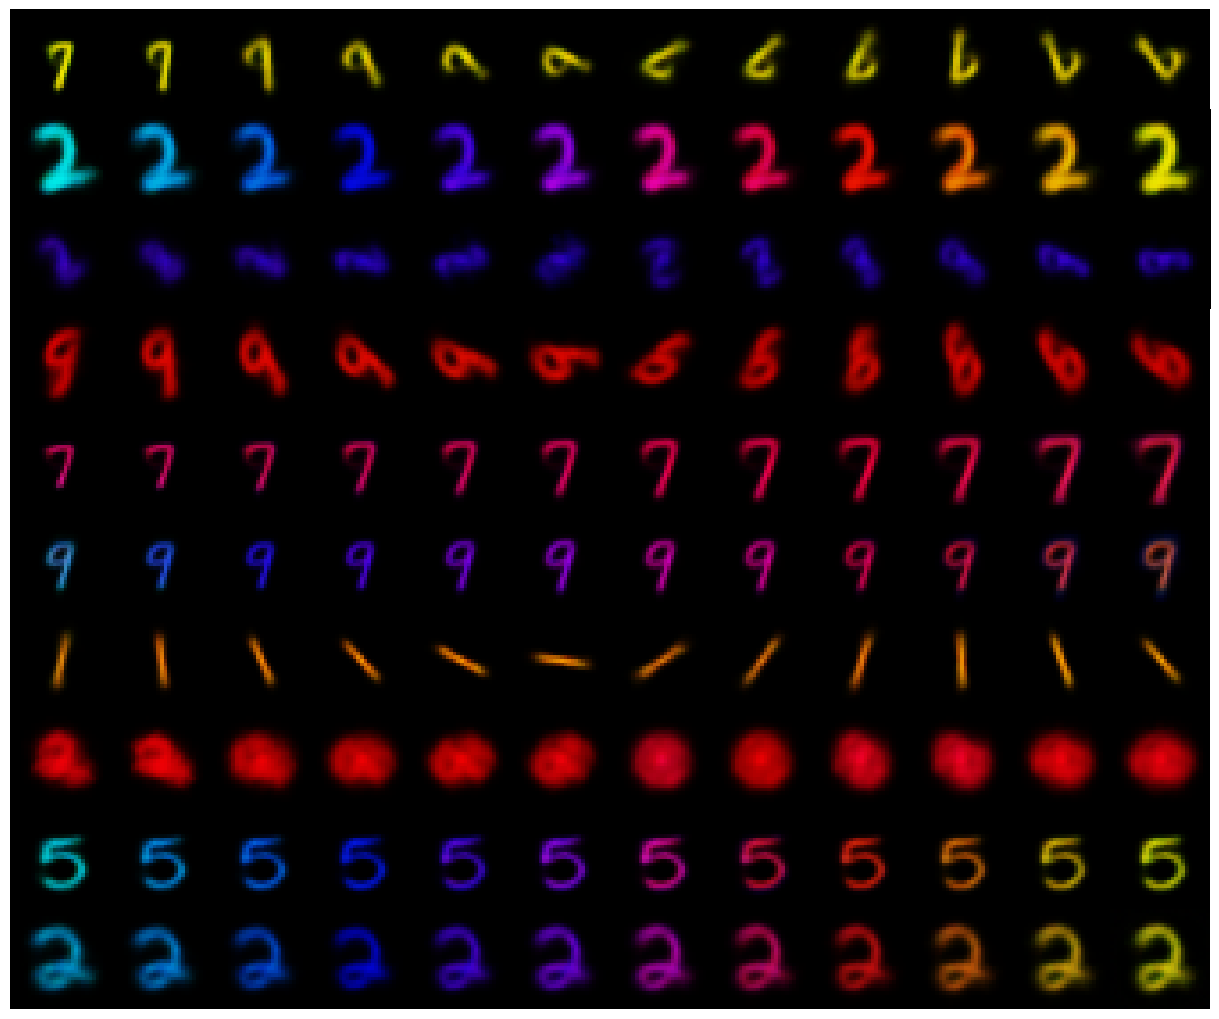

In [49]:
lim = model_rec.n_obs
im_size = 28

torch.manual_seed(888)
idx = torch.randperm(len(train_data))

# Train recon
fig, axes = plt.subplots(10, lim, figsize=(lim, 10))
for i in range(10):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig('plots/vamp/first_lvae_iaf_test_generation.png', bbox_inches='tight')

In [16]:
inp = iter(trainer.eval_loader).next()

inp.data = inp.data[12].unsqueeze(0).repeat(10, 1, 1, 1, 1)

output = model_rec(inp, epoch=100000)
recon = output.recon_x.detach()
z_seq = output.z_seq.detach()


NameError: name 'trainer' is not defined

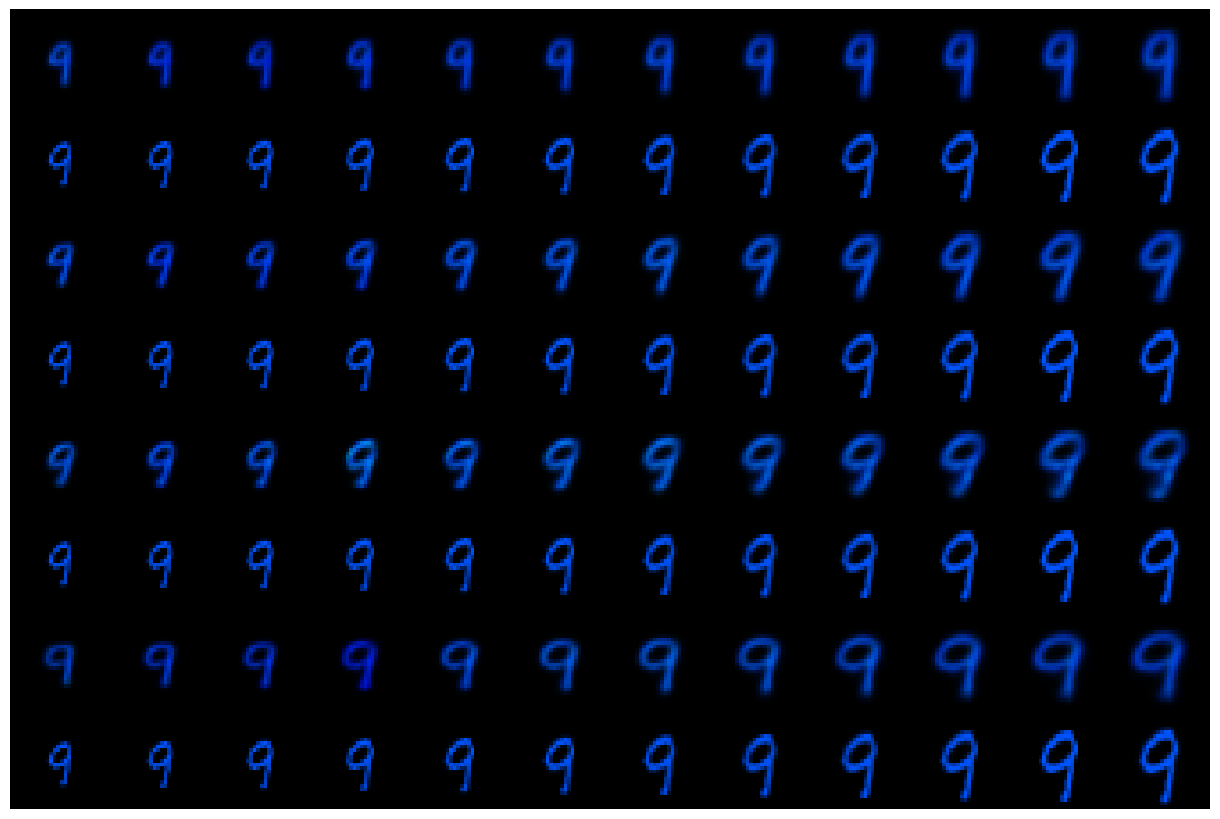

In [36]:
lim = model_rec.n_obs
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(2*4, lim, figsize=(lim, 4*2))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(np.moveaxis(recon[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    axes[1][k].imshow(np.moveaxis(inp.data[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
    i, t = 1, k
    axes[2][k].imshow(np.moveaxis(recon[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[2][k].axis('off')
    axes[3][k].imshow(np.moveaxis(inp.data[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[3][k].axis('off')
    i, t = 2, k
    axes[4][k].imshow(np.moveaxis(recon[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[4][k].axis('off')
    axes[5][k].imshow(np.moveaxis(inp.data[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[5][k].axis('off')
    i, t = 3, k
    axes[6][k].imshow(np.moveaxis(recon[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[6][k].axis('off')
    axes[7][k].imshow(np.moveaxis(inp.data[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[7][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig('plots/vamp/possible_evolutions_from_0.png', bbox_inches='tight')

RuntimeError: shape '[28, 28]' is invalid for input of size 2352

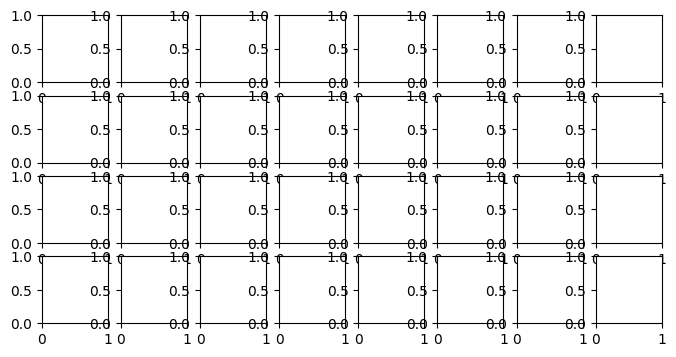

In [31]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [1]:
inp.data.shape

NameError: name 'inp' is not defined

In [24]:
a = torch.tensor([[1], [2], [3]])
a.repeat(1, 2).reshape(-1, 1)

tensor([[1],
        [1],
        [2],
        [2],
        [3],
        [3]])

In [25]:
inp = iter(trainer.eval_loader).next()

n_samples = 200

output = model_rec({'data': inp.data[:10].repeat(1, n_samples, 1, 1, 1).reshape(-1, 6, 3*784)}, epoch=100000)
recon = output.recon_x.detach()
z_seq = output.z_seq.detach()

NameError: name 'eval_loader' is not defined

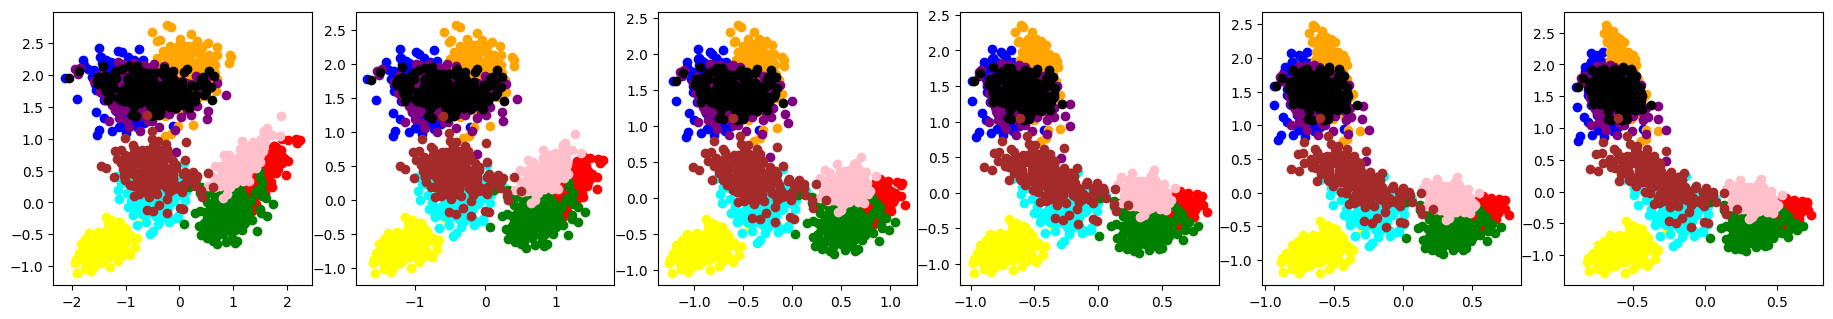

In [128]:
c = ['b', 'r', 'orange', 'yellow','cyan', 'purple', 'green', 'black', 'pink', 'brown']

fig, axes = plt.subplots(1, model_rec.n_obs, figsize=(model_rec.n_obs*3, 3))
torch.manual_seed(88)
for i in range(model_rec.n_obs):
    for j in range(len(c)):
        axes[i].scatter(z_seq[n_samples*j:n_samples*(j+1), i, 0].cpu(), z_seq[n_samples*j:n_samples*(j+1), i, 1].cpu(), c=c[j])
plt.tight_layout(pad=0)
#plt.savefig('plots/latent_2D_flow_shaping.png', bbox_inches="tight")

In [ ]:
model_rec.n

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(eval_data))

# Train recon
fig, axes = plt.subplots(8, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    axes[1][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 1, k
    axes[2][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    axes[3][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')
    i, t = 2, k
    axes[4][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[4][k].axis('off')
    axes[5][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[5][k].axis('off')
    i, t = 3, k
    axes[6][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[6][k].axis('off')
    axes[7][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[7][k].axis('off')